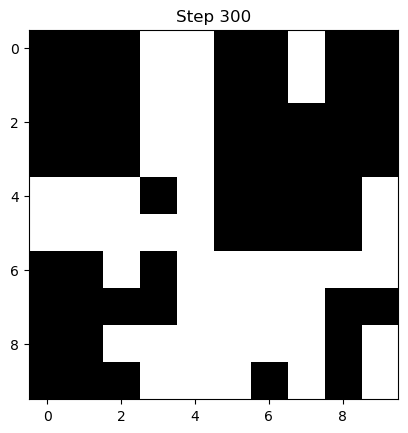

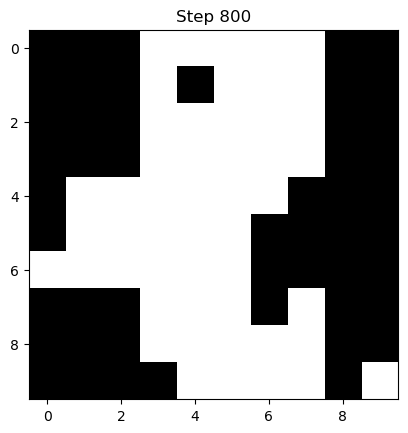

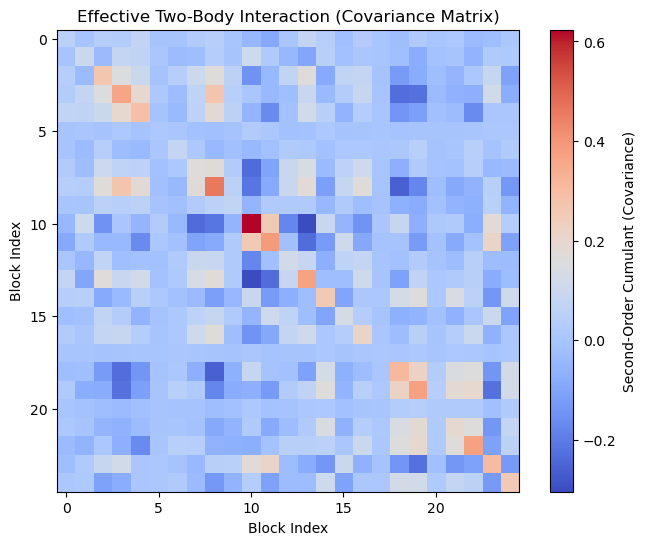

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Ising model
L = 10  # Lattice size (10x10)
J = 1.0  # Interaction strength
num_samples = 1000  # Number of Monte Carlo samples
burn_in = 200  # Burn-in steps
T_critical = 2.269  # Approximate critical temperature for 2D Ising model
T = T_critical  # Set temperature near criticality
beta = 1 / T  # Inverse temperature

# Function to compute energy of the Ising configuration
def compute_energy(spins):
    """Compute the energy of a given spin configuration."""
    energy = 0
    for i in range(L):
        for j in range(L):
            S = spins[i, j]
            # Nearest-neighbor interactions (periodic boundary conditions)
            neighbors = spins[(i + 1) % L, j] + spins[i, (j + 1) % L] + \
                        spins[(i - 1) % L, j] + spins[i, (j - 1) % L]
            energy += -J * S * neighbors
    return energy / 2  # Each bond counted twice

# Function to compute magnetization
def compute_magnetization(spins):
    return np.sum(spins)

# Metropolis-Hastings Monte Carlo for Ising Model
def metropolis_ising(num_samples, burn_in, beta):
    """Perform Metropolis-Hastings sampling for the Ising model."""
    spins = np.random.choice([-1, 1], size=(L, L))  # Initial random state
    samples = []
    
    for step in range(num_samples + burn_in):
        i, j = np.random.randint(0, L, size=2)  # Pick a random spin
        S = spins[i, j]
        
        # Compute energy change if flipped
        neighbors = spins[(i + 1) % L, j] + spins[i, (j + 1) % L] + \
                    spins[(i - 1) % L, j] + spins[i, (j - 1) % L]
        delta_E = 2 * J * S * neighbors  # Energy difference
        
        # Metropolis acceptance criterion
        if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
            spins[i, j] *= -1  # Flip the spin

        # Store sample after burn-in
        if step >= burn_in:
            samples.append(spins.copy())
            if step %500 == 0:
                plt.imshow(spins, cmap="gray", interpolation="nearest")
                plt.title(f"Step {step - burn_in}")
                plt.show()
            
        
    
    return np.array(samples)

# Run the MCMC simulation
ising_samples = metropolis_ising(num_samples, burn_in, beta)

# Convert samples into block magnetization
block_size = 2  # Coarse-graining scale
num_blocks = L // block_size
block_magnetization = np.zeros((num_samples, num_blocks, num_blocks))

for i in range(num_blocks):
    for j in range(num_blocks):
        block = ising_samples[:, i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        block_magnetization[:, i, j] = np.mean(block, axis=(1, 2))  # Average spin in block

# Flatten block magnetization for cumulant analysis
M_x = block_magnetization.reshape(num_samples, -1)

# Compute cumulants
mean_m = np.mean(M_x, axis=0)  # First-order cumulant
cov_m = np.cov(M_x, rowvar=False)  # Second-order cumulant

# Compute third-order cumulants
third_order_cumulants = {}
for i, j, k in itertools.product(range(M_x.shape[1]), repeat=3):
    third_order_cumulants[(i, j, k)] = np.mean(
        (M_x[:, i] - mean_m[i]) * (M_x[:, j] - mean_m[j]) * (M_x[:, k] - mean_m[k])
    )

# Compute fourth-order cumulants
fourth_order_cumulants = {}
for i, j, k, l in itertools.product(range(M_x.shape[1]), repeat=4):
    fourth_moment = np.mean(
        (M_x[:, i] - mean_m[i]) * (M_x[:, j] - mean_m[j]) * (M_x[:, k] - mean_m[k]) * (M_x[:, l] - mean_m[l])
    )
    correction = (
        cov_m[i, j] * cov_m[k, l] +
        cov_m[i, k] * cov_m[j, l] +
        cov_m[i, l] * cov_m[j, k]
    )
    fourth_order_cumulants[(i, j, k, l)] = fourth_moment - correction

# Display results
import pandas as pd

third_order_df = pd.DataFrame(list(third_order_cumulants.items()), columns=["Indices (i,j,k)", "Third-order Cumulant"])
fourth_order_df = pd.DataFrame(list(fourth_order_cumulants.items()), columns=["Indices (i,j,k,l)", "Fourth-order Cumulant"])

# tools.display_dataframe_to_user(name="Third-order Cumulants", dataframe=third_order_df)
# tools.display_dataframe_to_user(name="Fourth-order Cumulants", dataframe=fourth_order_df)

# Plot second-order cumulants (covariance matrix)
plt.figure(figsize=(8, 6))
plt.imshow(cov_m, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Second-Order Cumulant (Covariance)")
plt.title("Effective Two-Body Interaction (Covariance Matrix)")
plt.xlabel("Block Index")
plt.ylabel("Block Index")
plt.show()


Running MCMC for T = 1.0...


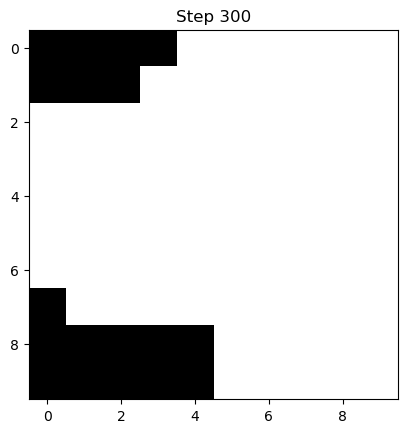

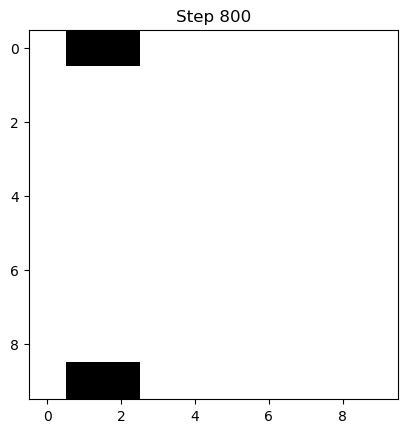

Running MCMC for T = 1.3333333333333333...


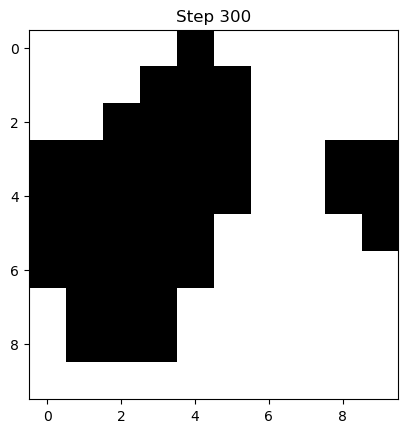

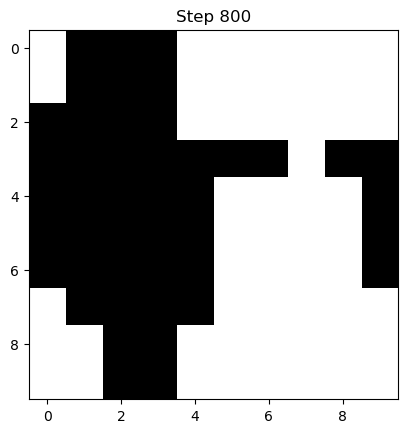

Running MCMC for T = 1.6666666666666665...


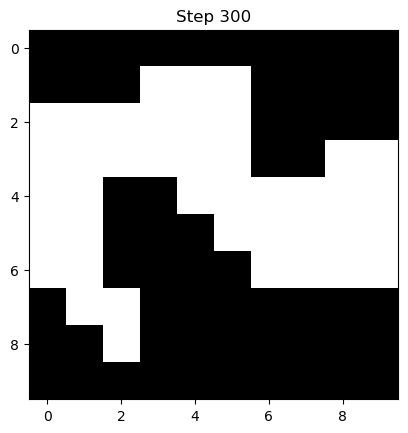

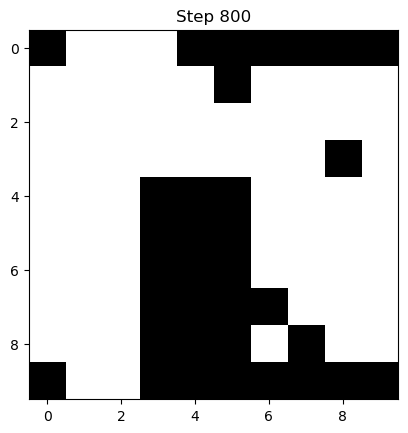

Running MCMC for T = 2.0...


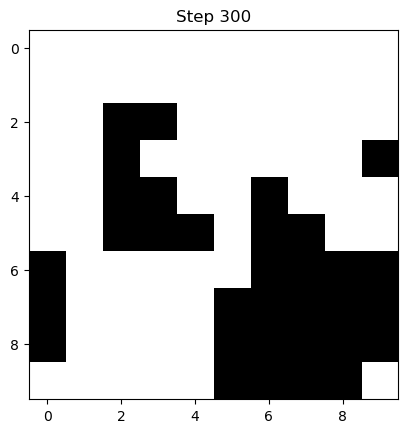

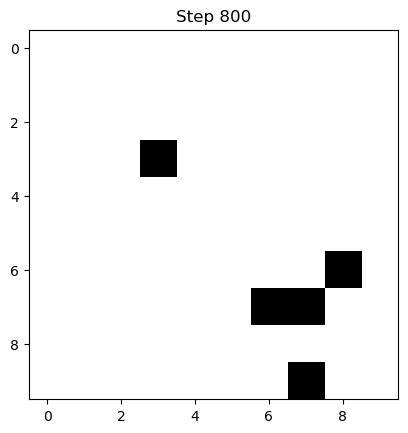

Running MCMC for T = 2.333333333333333...


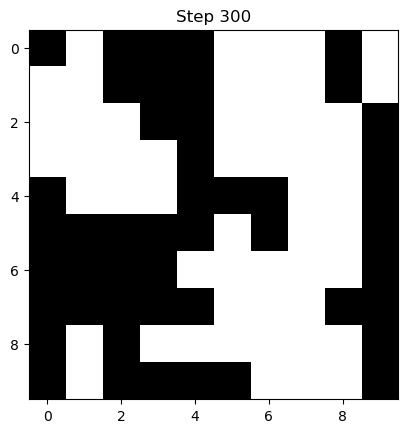

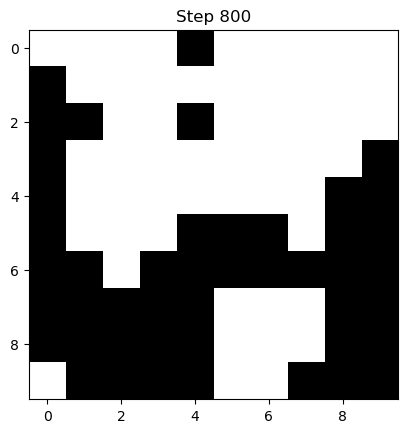

Running MCMC for T = 2.6666666666666665...


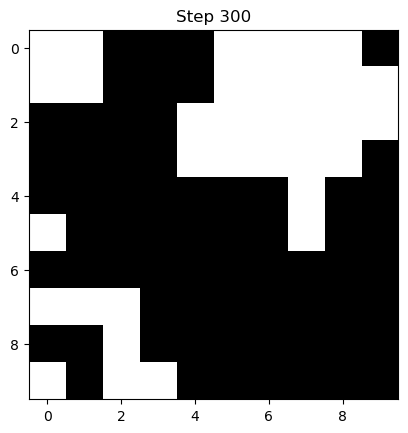

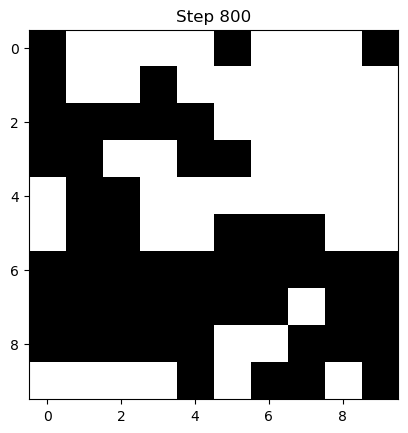

Running MCMC for T = 3.0...


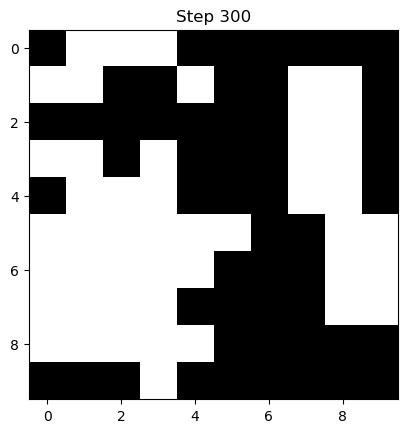

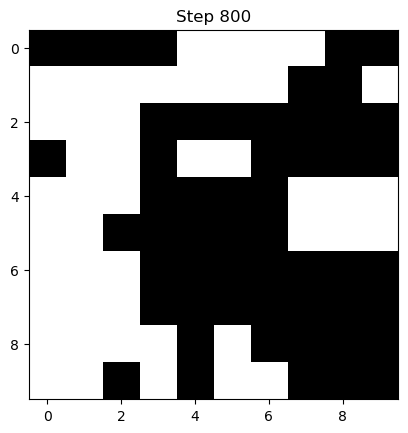

Running MCMC for T = 3.333333333333333...


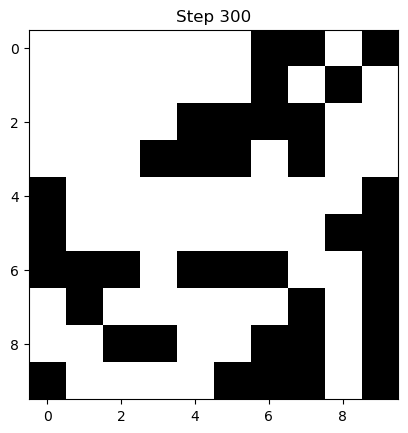

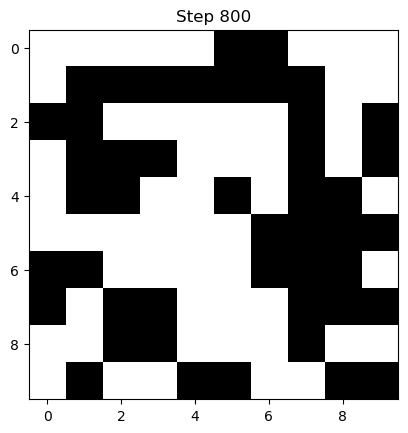

Running MCMC for T = 3.6666666666666665...


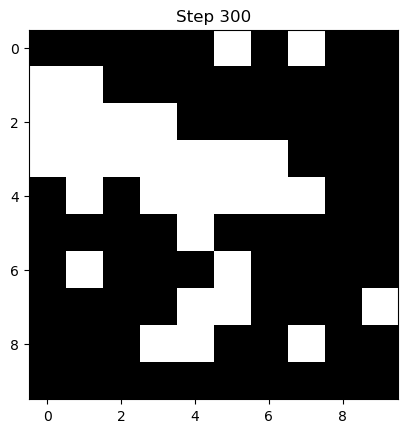

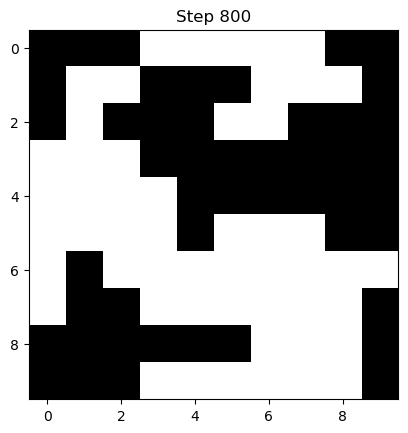

Running MCMC for T = 4.0...


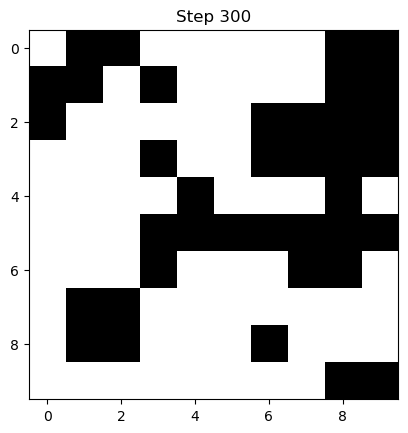

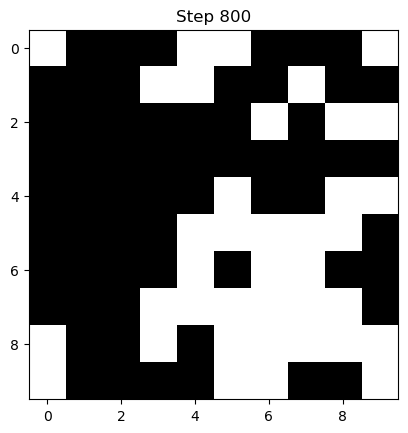

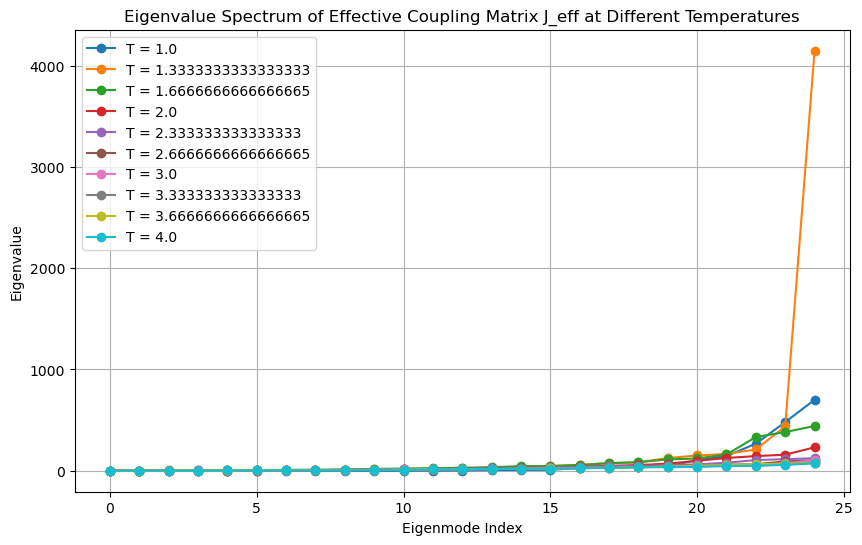

In [20]:
# Define multiple temperatures around the critical temperature
temperatures = np.linspace(1.0, 4.0, 10)
beta_values = [1/T for T in temperatures]

# Store results for different temperatures
effective_actions = {}
eigenvalue_spectra = {}

for beta, T in zip(beta_values, temperatures):
    print(f"Running MCMC for T = {T}...")
    
    # Step 1: Monte Carlo Simulation at Temperature T
    ising_samples = metropolis_ising(num_samples, burn_in, beta)
    
    # Step 2: Compute Block Magnetization (Coarse-Graining)
    block_magnetization = np.zeros((num_samples, num_blocks, num_blocks))
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = ising_samples[:, i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            block_magnetization[:, i, j] = np.mean(block, axis=(1, 2))  # Average spin in block
    
    M_x = block_magnetization.reshape(num_samples, -1)  # Flatten the magnetization

    # Step 3: Compute Cumulants
    mean_m = np.mean(M_x, axis=0)  # First-order cumulant
    cov_m = np.cov(M_x, rowvar=False)  # Second-order cumulant

    # Compute Effective Coupling Matrix J_eff
    J_eff = np.linalg.pinv(cov_m)  # Compute inverse covariance

    # Store effective action components
    effective_actions[T] = J_eff

    # Compute Eigenvalues of J_eff
    eigenvalues, eigenvectors = np.linalg.eigh(J_eff)
    eigenvalue_spectra[T] = eigenvalues

# Plot Eigenvalue Spectra to Show Phase Transition
plt.figure(figsize=(10, 6))
for T in temperatures:
    plt.plot(eigenvalue_spectra[T], 'o-', label=f"T = {T}")

plt.xlabel("Eigenmode Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalue Spectrum of Effective Coupling Matrix J_eff at Different Temperatures")
plt.legend()
plt.grid()
plt.show()


In [23]:
import numpy as np

# Perform a Monte Carlo simulation using the Effective Action J_eff
def metropolis_reduced(num_samples, burn_in, J_eff, beta):
    """
    Monte Carlo simulation using the effective action with J_eff.
    """
    num_blocks = J_eff.shape[0]  # Number of coarse-grained magnetization sites
    M = np.random.choice([-1, 1], size=num_blocks)  # Initial magnetization state

    samples = []

    for step in range(num_samples + burn_in):
        i = np.random.randint(0, num_blocks)  # Pick a random site
        dE = 2 * M[i] * np.dot(J_eff[i], M)  # Compute energy difference

        # Metropolis acceptance criterion
        if dE < 0 or np.random.rand() < np.exp(-beta * dE):
            M[i] *= -1  # Flip the spin

        # Store sample after burn-in
        if step >= burn_in:
            samples.append(M.copy())
            plt.imshow()

    return np.array(samples)

# Choose an effective temperature close to the critical temperature
T_reduced = 3.0  # Near criticality
beta_reduced = 1 / T_reduced

# Select J_eff at this temperature
J_eff_reduced = effective_actions[T_reduced]

# Run the reduced Monte Carlo simulation
num_samples_reduced = 5000
burn_in_reduced = 1000
reduced_samples = metropolis_reduced(num_samples_reduced, burn_in_reduced, J_eff_reduced, beta_reduced)

# Compute magnetization statistics
magnetization_reduced = np.mean(reduced_samples, axis=1)

# Plot the magnetization evolution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(magnetization_reduced, label="Coarse-grained Magnetization")
plt.xlabel("Monte Carlo Step")
plt.ylabel("Magnetization")
plt.title("Monte Carlo Simulation Using Effective Action")
plt.legend()
plt.grid()
plt.show()


TypeError: imshow() missing 1 required positional argument: 'X'

[[ 1 -1 -1 ... -1  1 -1]
 [ 1 -1 -1 ... -1  1  1]
 [ 1 -1 -1 ... -1  1  1]
 ...
 [ 1 -1 -1 ... -1  1 -1]
 [ 1 -1 -1 ... -1  1 -1]
 [ 1 -1 -1 ... -1  1 -1]]
[[-1 -1  1 ... -1  1 -1]
 [-1 -1  1 ... -1  1 -1]
 [-1 -1  1 ... -1  1 -1]
 ...
 [-1 -1  1 ... -1  1 -1]
 [-1 -1  1 ... -1  1 -1]
 [-1 -1  1 ... -1  1 -1]]
[[ 1 -1 -1 ... -1 -1  1]
 [ 1 -1 -1 ... -1 -1  1]
 [ 1 -1 -1 ... -1 -1  1]
 ...
 [ 1 -1 -1 ... -1 -1  1]
 [ 1 -1 -1 ... -1 -1  1]
 [ 1 -1 -1 ... -1 -1  1]]
[[-1 -1  1 ...  1  1  1]
 [-1 -1  1 ...  1  1  1]
 [-1 -1  1 ...  1  1  1]
 ...
 [-1  1  1 ...  1  1  1]
 [-1  1  1 ...  1  1  1]
 [-1  1  1 ...  1  1  1]]
[[-1  1  1 ...  1 -1 -1]
 [-1  1  1 ...  1 -1 -1]
 [-1  1  1 ...  1 -1 -1]
 ...
 [-1  1  1 ...  1 -1 -1]
 [-1  1  1 ...  1 -1 -1]
 [-1  1  1 ...  1 -1 -1]]
[[-1  1 -1 ...  1  1 -1]
 [-1  1 -1 ...  1  1 -1]
 [-1  1 -1 ...  1  1 -1]
 ...
 [-1  1 -1 ...  1  1 -1]
 [-1  1 -1 ...  1  1 -1]
 [-1  1 -1 ...  1  1 -1]]
[[-1  1 -1 ... -1  1  1]
 [-1  1 -1 ... -1  1  1]
 [-1  1 -1 ...

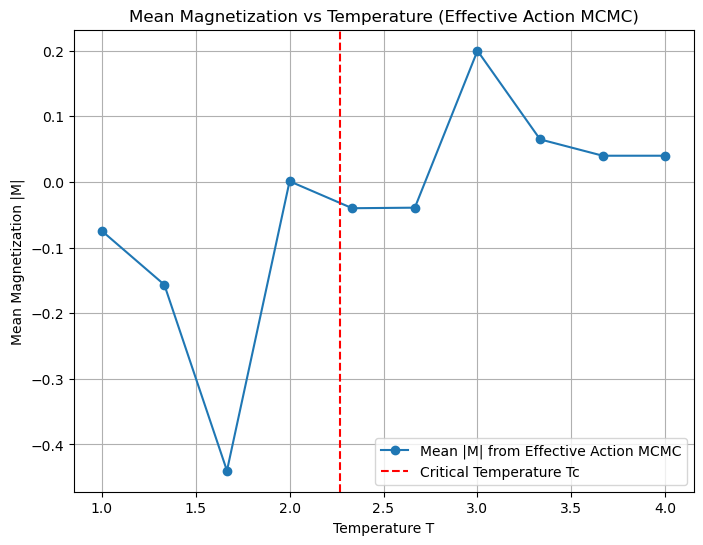

In [22]:
# Run the reduced Monte Carlo simulation for multiple temperatures
magnetization_vs_T = {}

for T_reduced in temperatures:
    beta_reduced = 1 / T_reduced
    J_eff_reduced = effective_actions[T_reduced]  # Get the effective action at this temperature

    # Run the reduced Monte Carlo simulation
    reduced_samples = metropolis_reduced(num_samples_reduced, burn_in_reduced, J_eff_reduced, beta_reduced)
    print(reduced_samples)

    # Compute mean magnetization
    magnetization_vs_T[T_reduced] = np.mean(reduced_samples, axis=1)  # Absolute to avoid sign fluctuations

# Plot the mean magnetization as a function of temperature
plt.figure(figsize=(8, 6))
mean_magnetizations = [np.mean(magnetization_vs_T[T]) for T in temperatures]

plt.plot(temperatures, mean_magnetizations, 'o-', label="Mean |M| from Effective Action MCMC")
plt.axvline(x=2.269, linestyle="--", color="red", label="Critical Temperature Tc")
plt.xlabel("Temperature T")
plt.ylabel("Mean Magnetization |M|")
plt.title("Mean Magnetization vs Temperature (Effective Action MCMC)")
plt.legend()
plt.grid()
plt.show()


Running MCMC for T = 1.5...


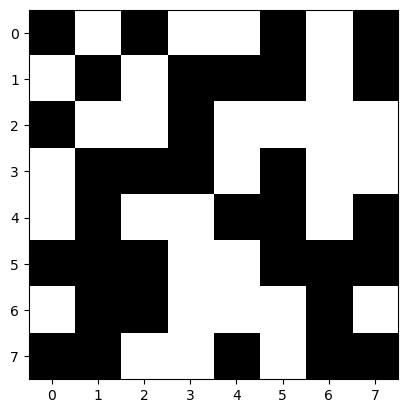

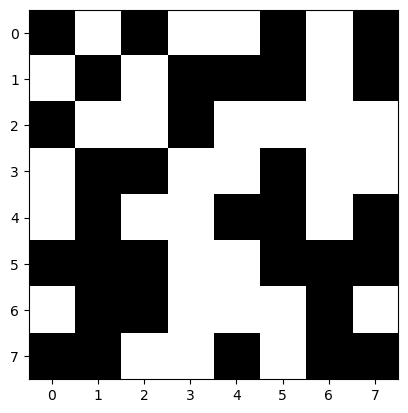

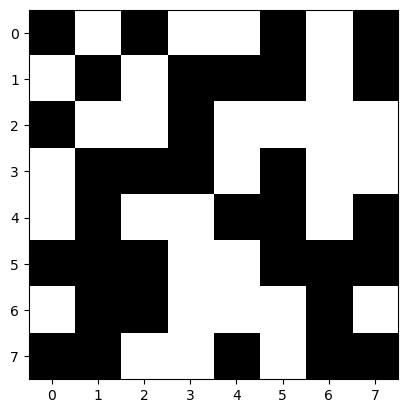

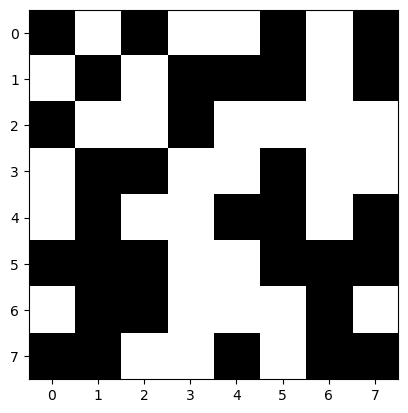

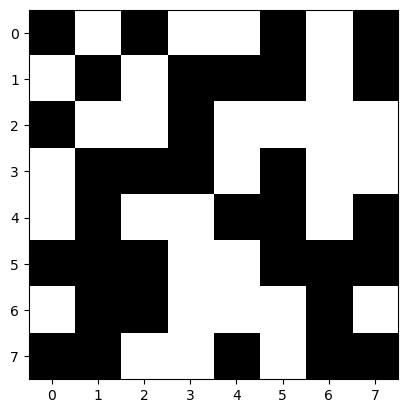

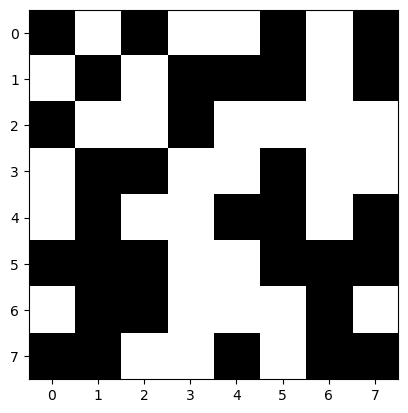

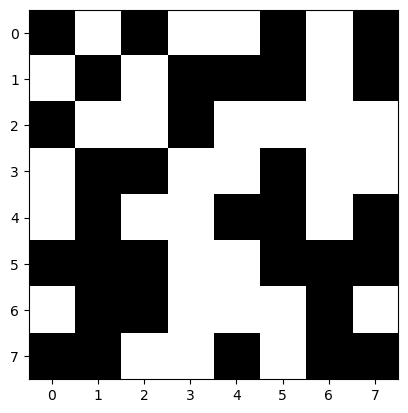

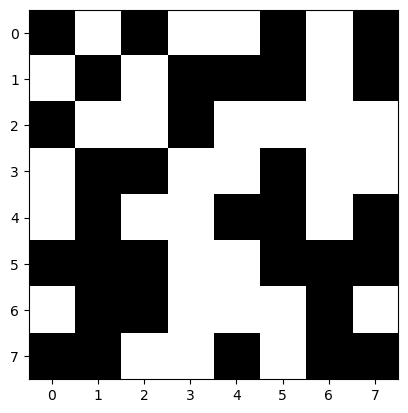

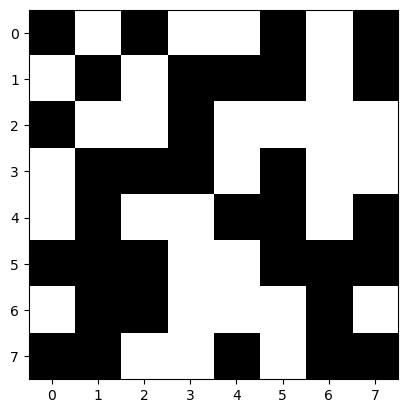

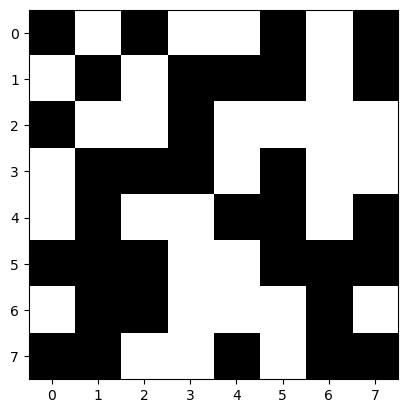

Running MCMC for T = 2.0...


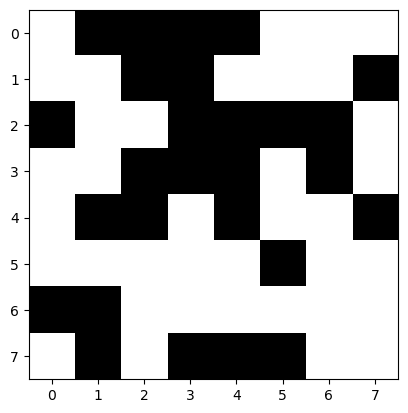

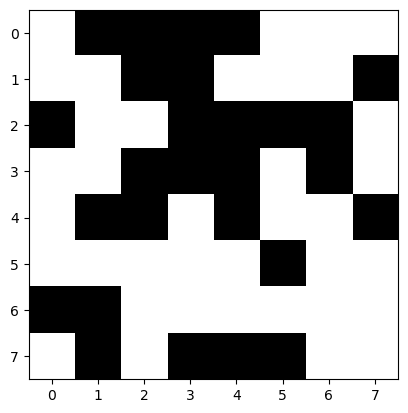

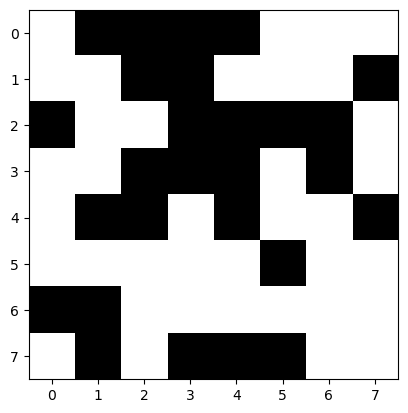

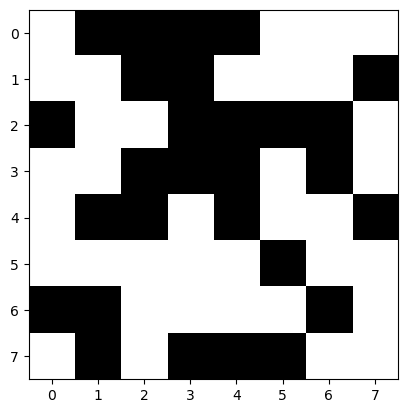

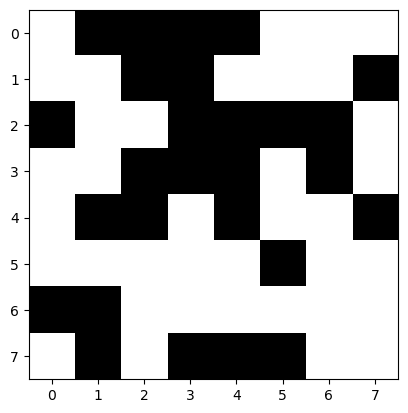

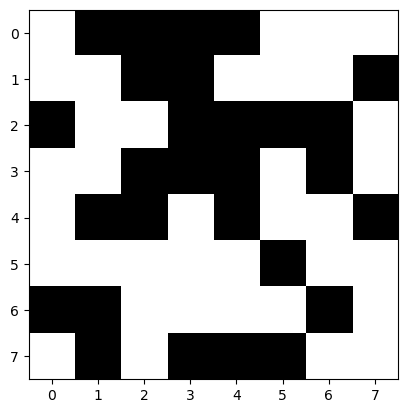

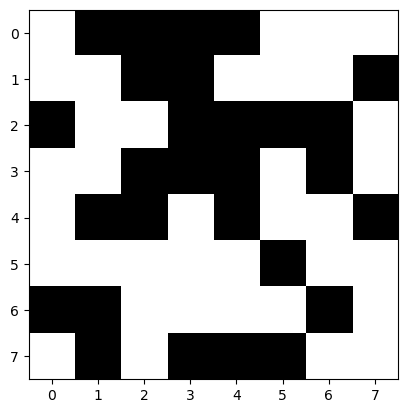

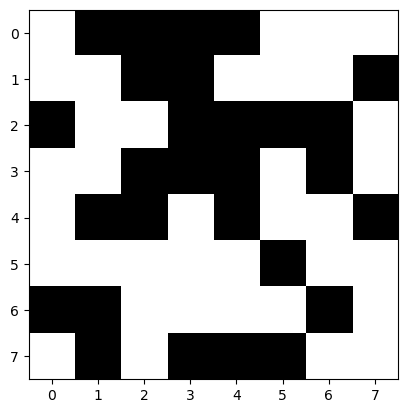

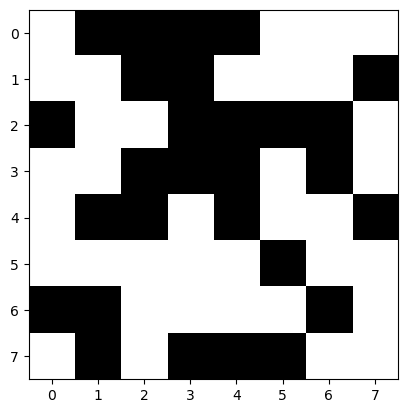

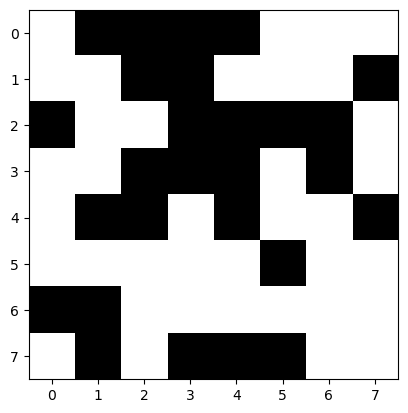

Running MCMC for T = 2.269...


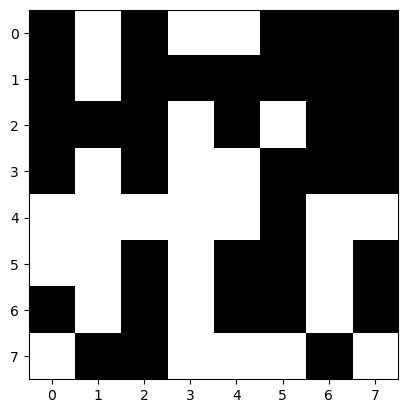

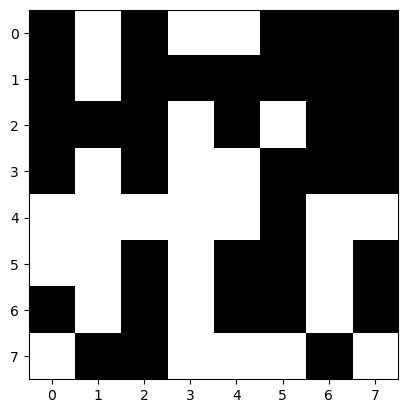

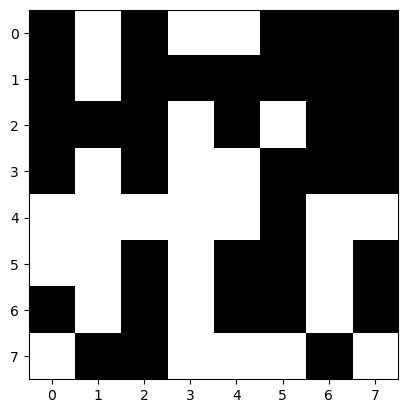

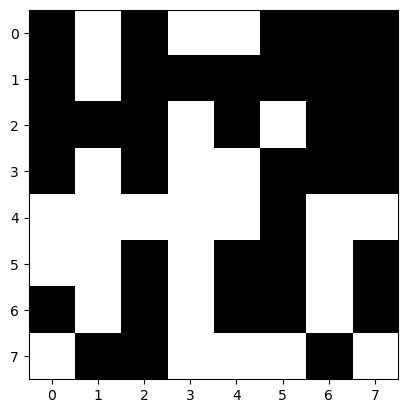

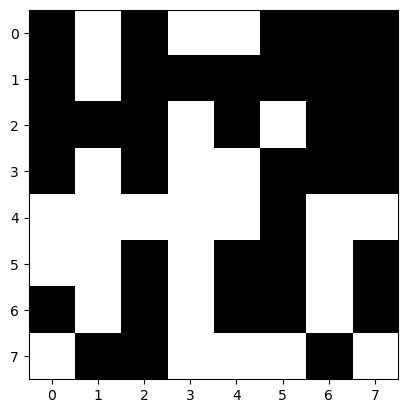

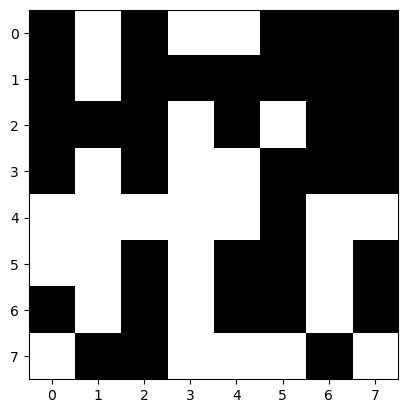

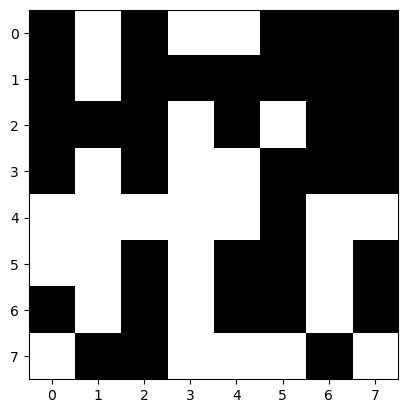

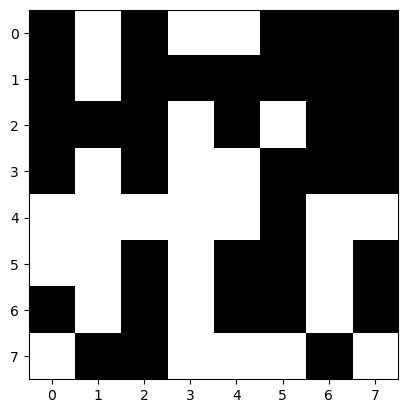

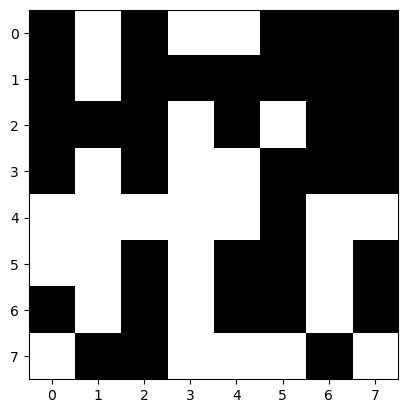

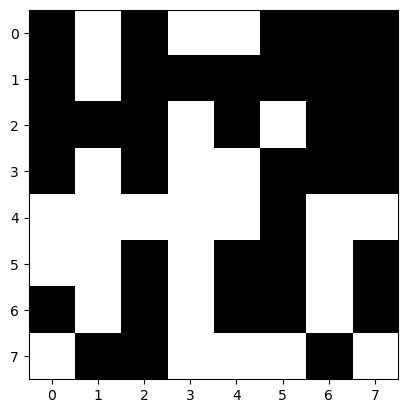

Running MCMC for T = 2.5...


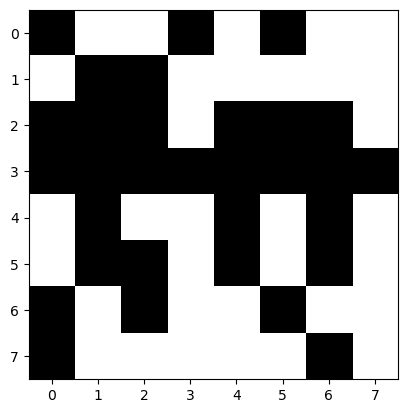

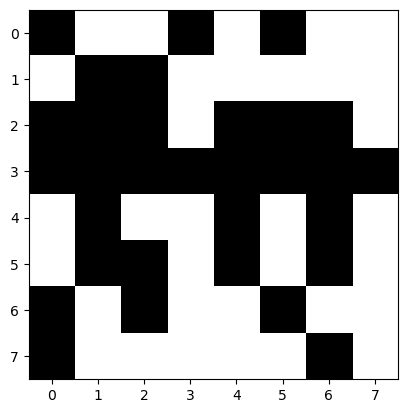

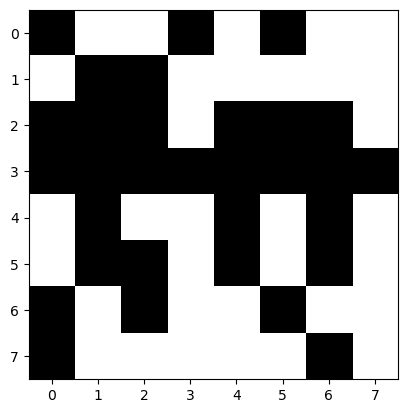

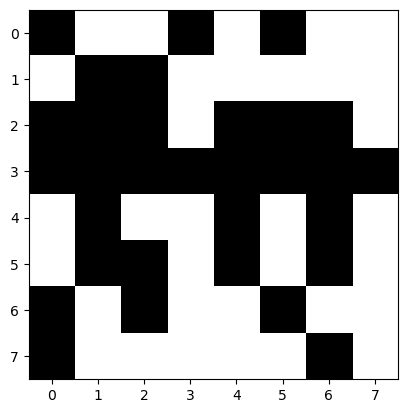

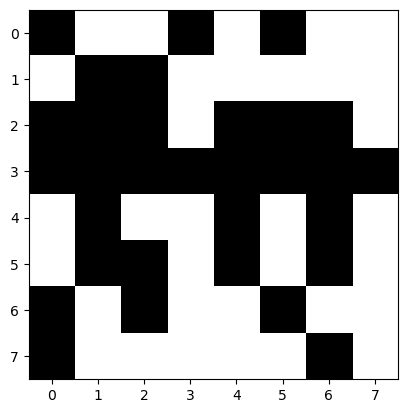

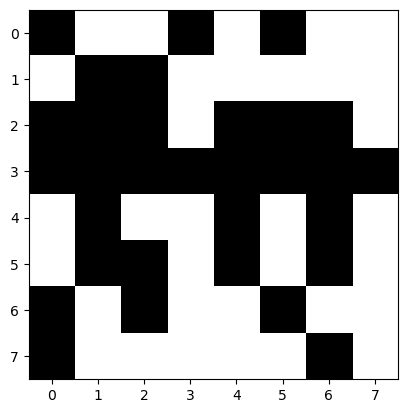

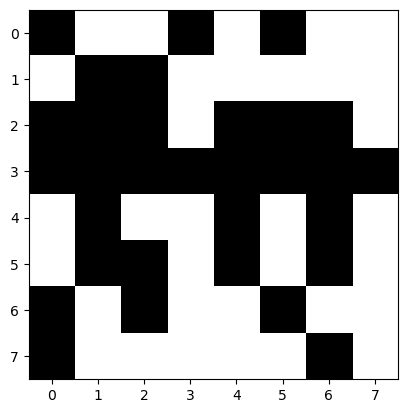

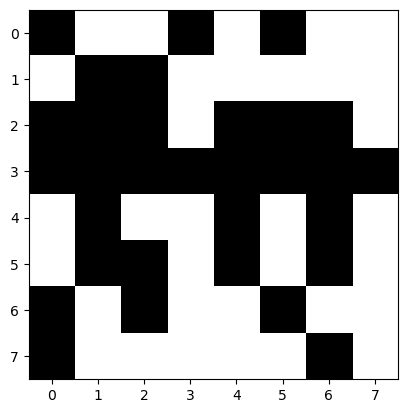

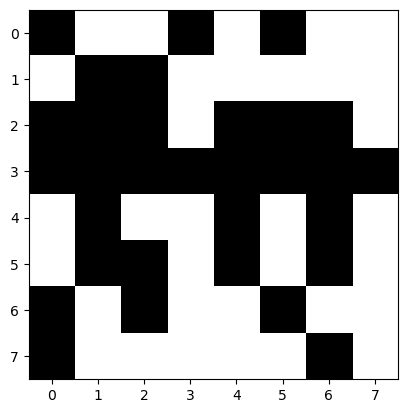

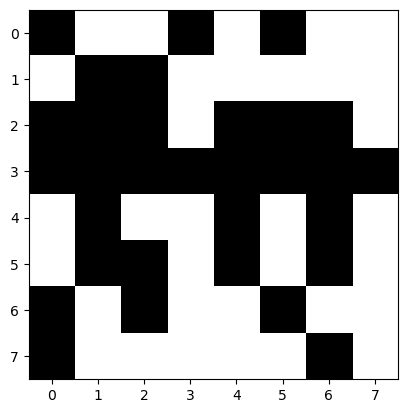

Running MCMC for T = 3.0...


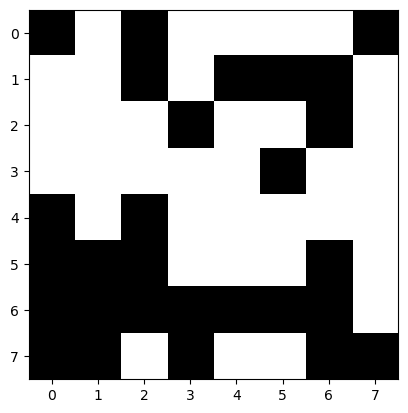

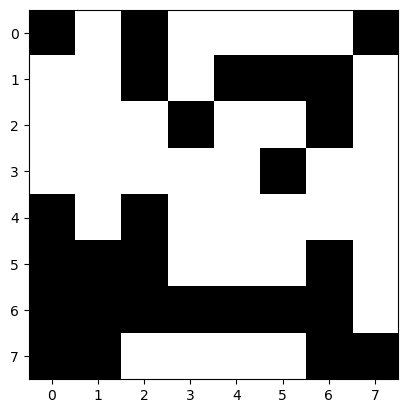

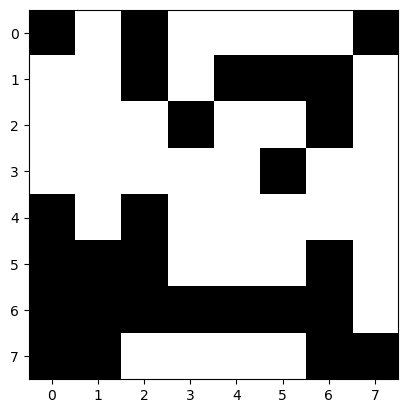

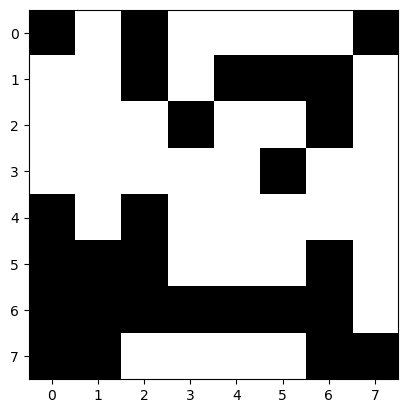

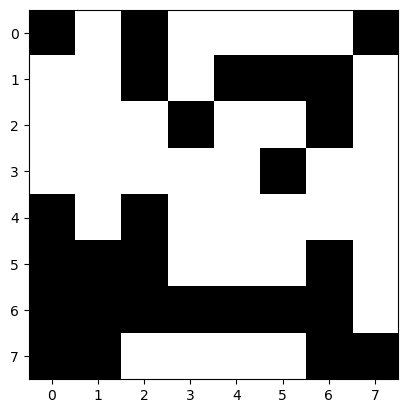

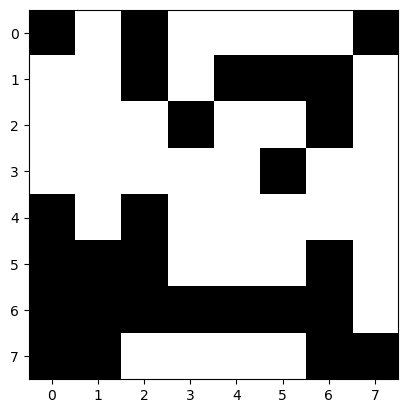

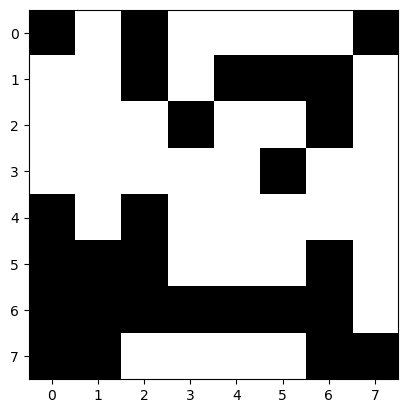

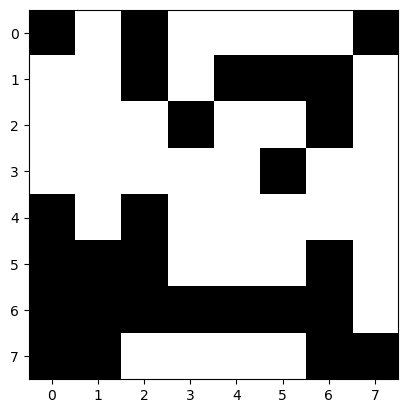

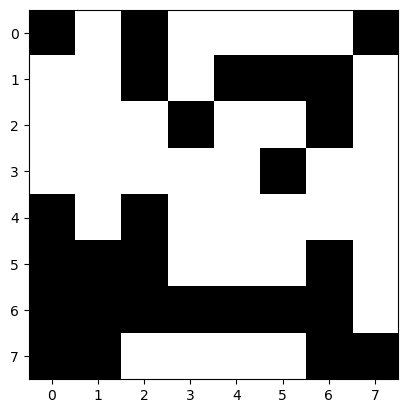

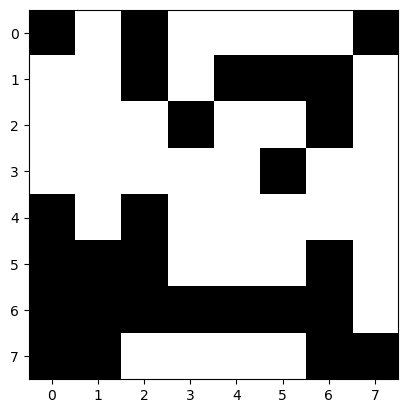

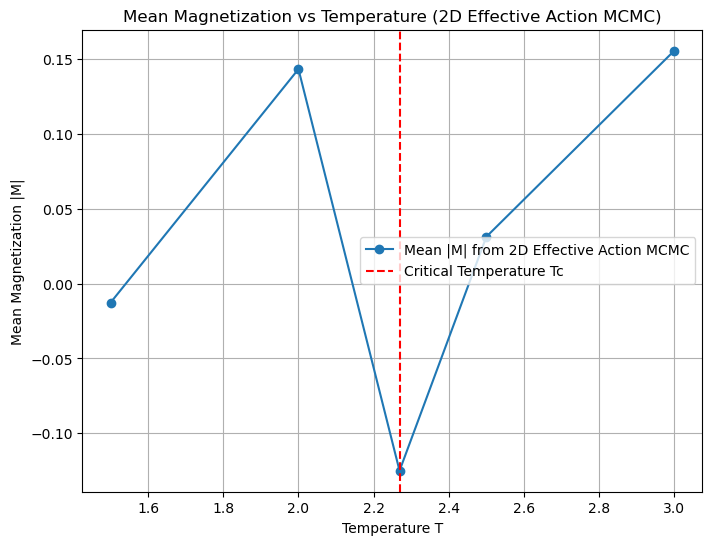

[-0.01271875, 0.14321875, -0.125, 0.03125, 0.1555]

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define Monte Carlo simulation for the Ising model
def metropolis_ising_2D(L, num_samples, burn_in, beta):
    """Perform Metropolis-Hastings sampling for a 2D Ising model."""
    spins = np.random.choice([-1, 1], size=(L, L))  # Initial random spin state
    samples = []

    for step in range(num_samples + burn_in):
        i, j = np.random.randint(0, L, size=2)  # Pick a random spin
        S = spins[i, j]
        
        # Compute energy change if flipped (nearest-neighbor interaction)
        neighbors = spins[(i + 1) % L, j] + spins[i, (j + 1) % L] + \
                    spins[(i - 1) % L, j] + spins[i, (j - 1) % L]
        delta_E = 2 * S * neighbors  # Energy difference
        
        # Metropolis acceptance criterion
        if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
            spins[i, j] *= -1  # Flip the spin

        # Store sample after burn-in
        if step >= burn_in:
            samples.append(spins.copy())

    return np.array(samples)

# Function to compute the coarse-grained magnetization in 2D
def coarse_grain_2D(spins, block_size):
    """Compute block-averaged magnetization for 2D Ising configurations."""
    L = spins.shape[1]  # Lattice size
    num_blocks = L // block_size  # Number of blocks in each dimension
    block_magnetization = np.zeros((spins.shape[0], num_blocks, num_blocks))

    for i in range(num_blocks):
        for j in range(num_blocks):
            block = spins[:, i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            block_magnetization[:, i, j] = np.mean(block, axis=(1, 2))  # Average spin in block

    return block_magnetization

# Function for Monte Carlo simulation using the 2D effective action
def metropolis_reduced_2D(num_samples, burn_in, J_eff, beta):
    """Monte Carlo simulation using the effective action with J_eff in 2D."""
    num_blocks_side = int(np.sqrt(J_eff.shape[0]))  # Recover 2D shape
    M = np.random.choice([-1, 1], size=(num_blocks_side, num_blocks_side))  # Initial magnetization state

    samples = []

    for step in range(num_samples + burn_in):
        i, j = np.random.randint(0, num_blocks_side, size=2)  # Pick a random site
        dE = 2 * M[i, j] * np.sum(J_eff[i * num_blocks_side + j] * M.flatten())  # Compute energy difference

        # Metropolis acceptance criterion
        if dE < 0 or np.random.rand() < np.exp(-beta * dE):
            M[i, j] *= -1  # Flip the spin

        # Store sample after burn-in
        if step >= burn_in:
            samples.append(M.copy())
            if step%100==0:
                plt.imshow(M, cmap="gray", interpolation="nearest")
                plt.show()

    return np.array(samples)

# Simulation parameters
L = 32  # Lattice size (16x16 for better resolution)
num_samples = 1000  # Number of Monte Carlo samples
burn_in = 500  # Burn-in steps
block_size = 4  # Coarse-graining scale
num_blocks = L // block_size

# Define temperatures to study
temperatures = [1.5, 2.0, 2.269, 2.5, 3.0]  # Below, near, and above Tc
beta_values = [1/T for T in temperatures]

# Store results
effective_actions = {}
magnetization_vs_T_2D = {}

# Run Monte Carlo simulations and extract effective actions
for beta, T in zip(beta_values, temperatures):
    print(f"Running MCMC for T = {T}...")

    # Step 1: Monte Carlo Simulation at Temperature T
    ising_samples = metropolis_ising_2D(L, num_samples, burn_in, beta)

    # Step 2: Compute Coarse-Grained Magnetization (2D Blocking)
    block_magnetization = coarse_grain_2D(ising_samples, block_size)

    # Step 3: Compute Second-Order Cumulant (Covariance in 2D)
    num_block_sites = num_blocks * num_blocks  # Total number of block magnetization sites
    M_x = block_magnetization.reshape(num_samples, num_block_sites)  # Flatten to match J_eff

    mean_m = np.mean(M_x, axis=0)  # First-order cumulant
    cov_m = np.cov(M_x, rowvar=False)  # Second-order cumulant

    # Compute Effective Coupling Matrix J_eff
    J_eff = np.linalg.pinv(cov_m)  # Compute inverse covariance

    # Store effective action components
    effective_actions[T] = J_eff

    # Step 4: Monte Carlo Simulation Using the Effective Action
    beta_reduced = 1 / T
    reduced_samples_2D = metropolis_reduced_2D(num_samples, burn_in, J_eff, beta_reduced)

    # Compute mean absolute magnetization
    magnetization_vs_T_2D[T] = np.mean(reduced_samples_2D, axis=(1, 2))  # Mean over samples

# Plot mean magnetization vs temperature for the 2D effective action MCMC
plt.figure(figsize=(8, 6))
mean_magnetizations_2D = [np.mean(magnetization_vs_T_2D[T]) for T in temperatures]

plt.plot(temperatures, mean_magnetizations_2D, 'o-', label="Mean |M| from 2D Effective Action MCMC")
plt.axvline(x=2.269, linestyle="--", color="red", label="Critical Temperature Tc")
plt.xlabel("Temperature T")
plt.ylabel("Mean Magnetization |M|")
plt.title("Mean Magnetization vs Temperature (2D Effective Action MCMC)")
plt.legend()
plt.grid()
plt.show()

# Display computed magnetization values
mean_magnetizations_2D


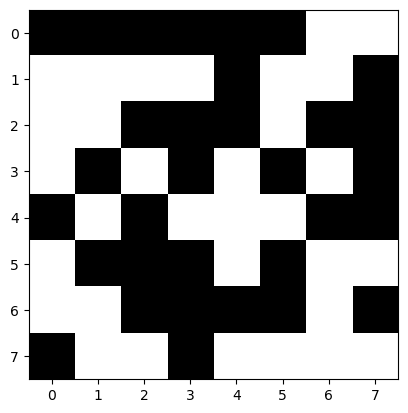

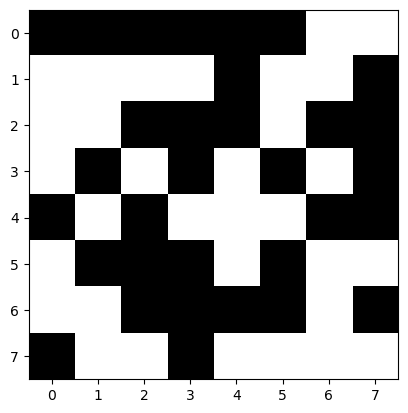

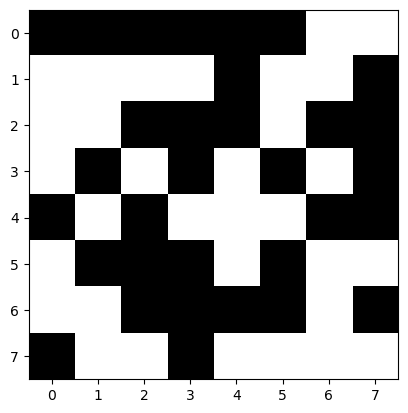

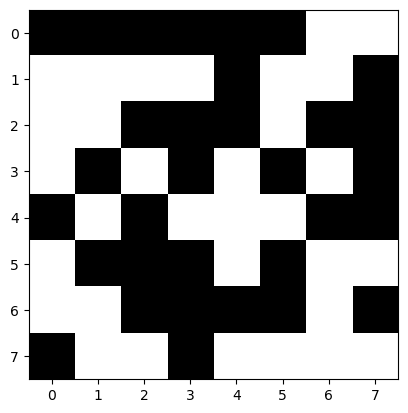

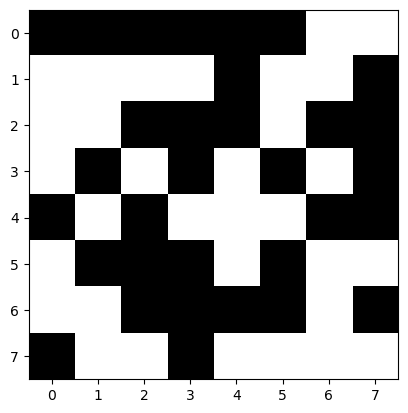

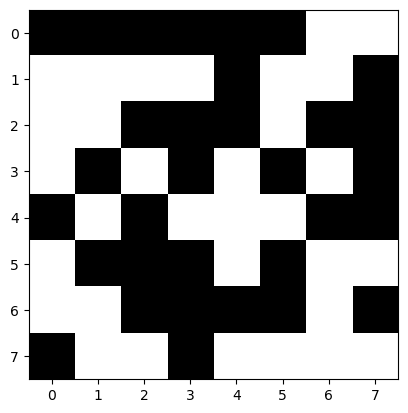

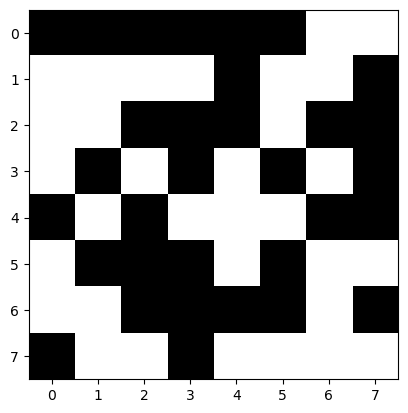

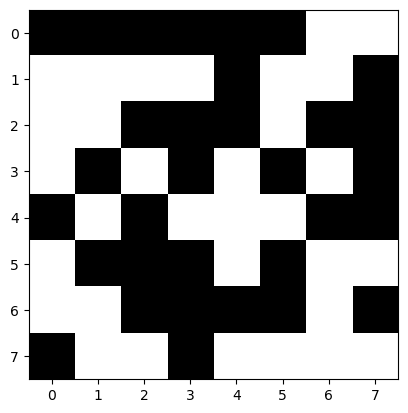

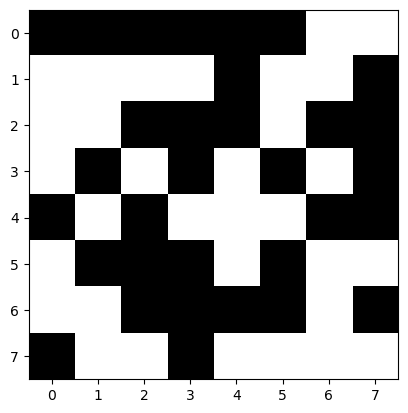

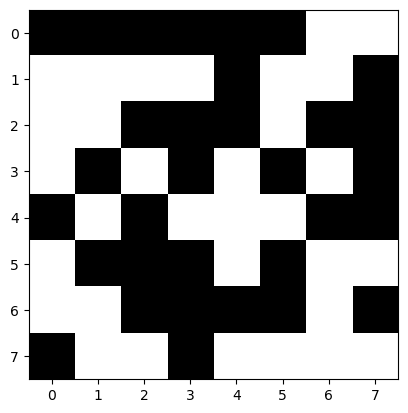

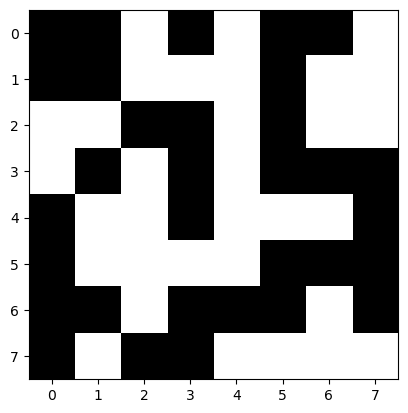

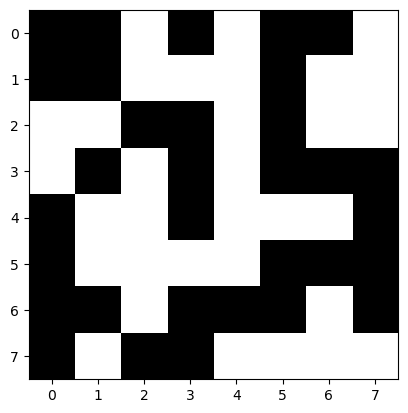

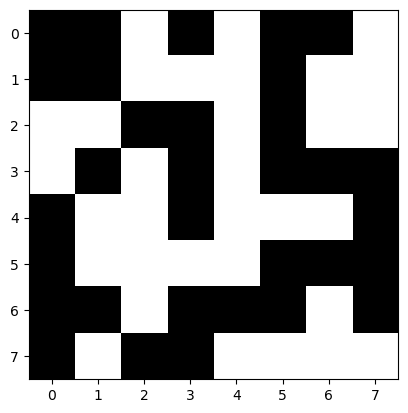

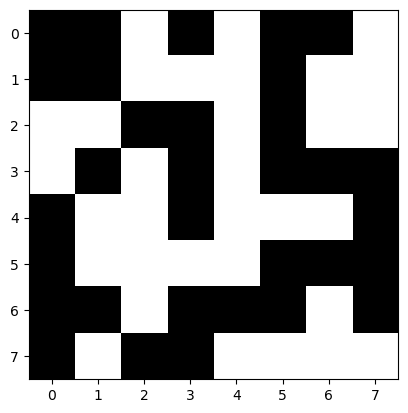

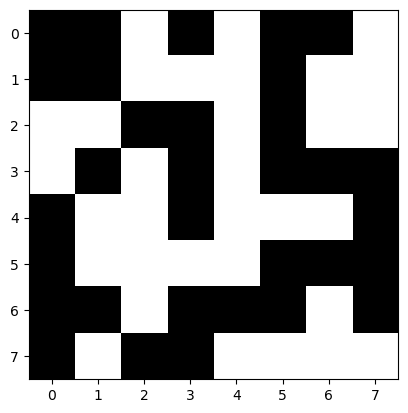

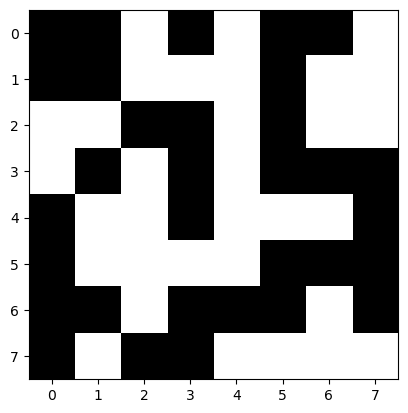

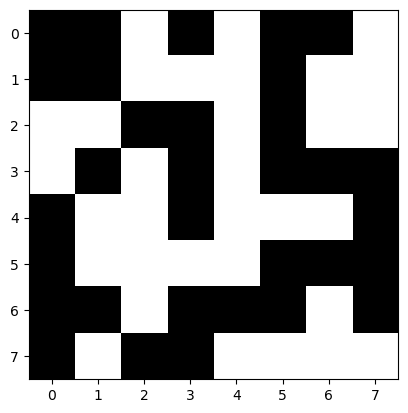

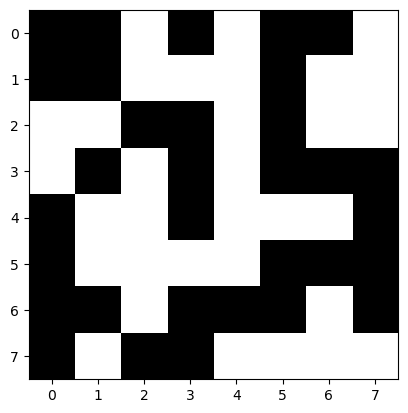

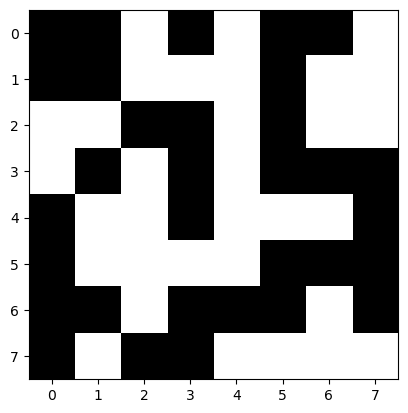

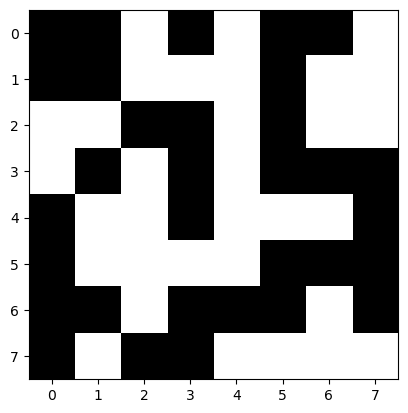

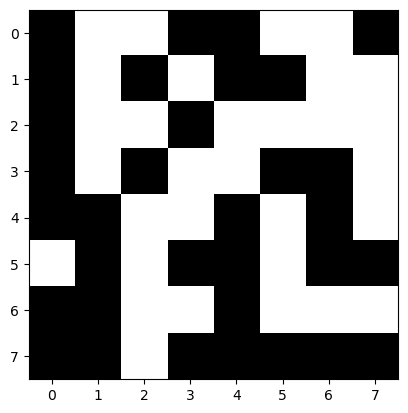

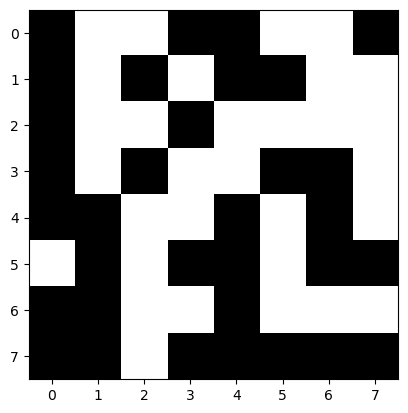

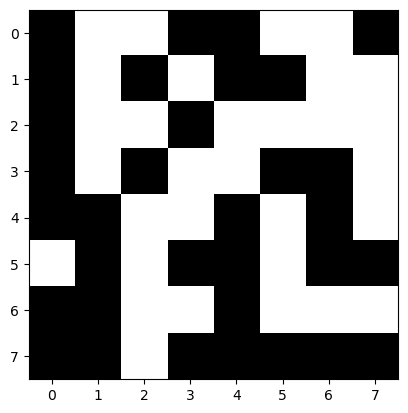

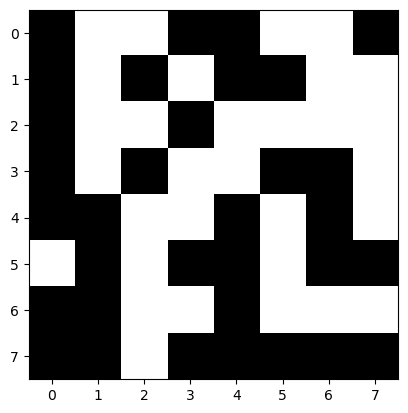

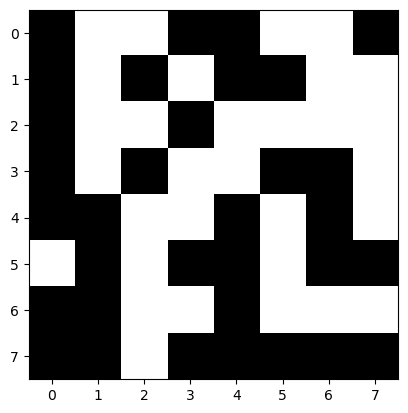

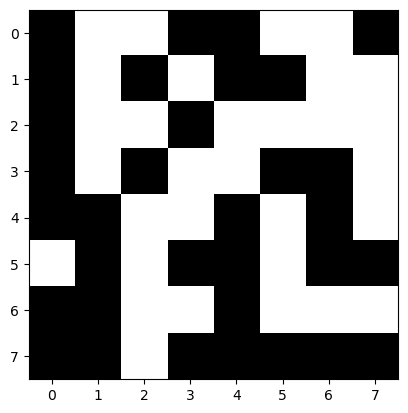

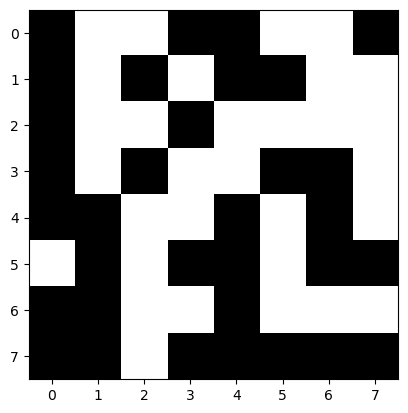

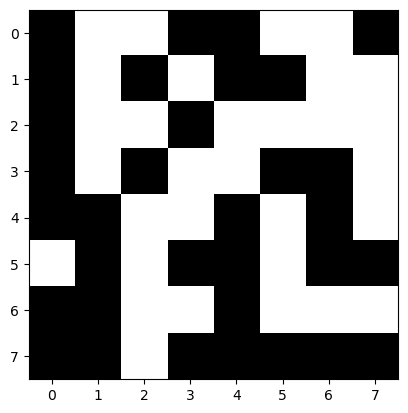

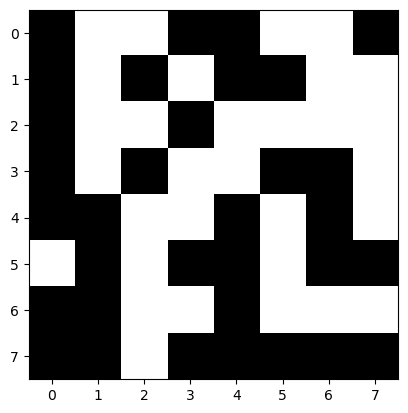

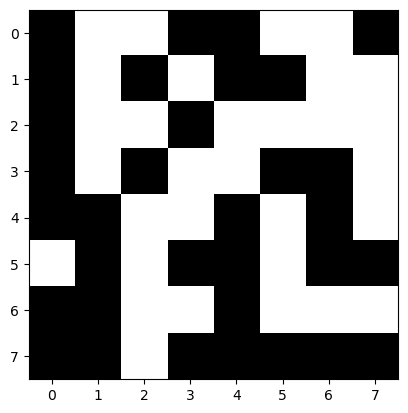

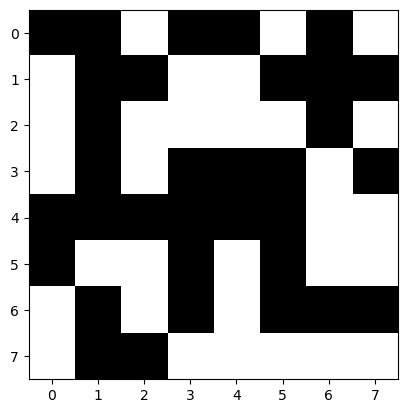

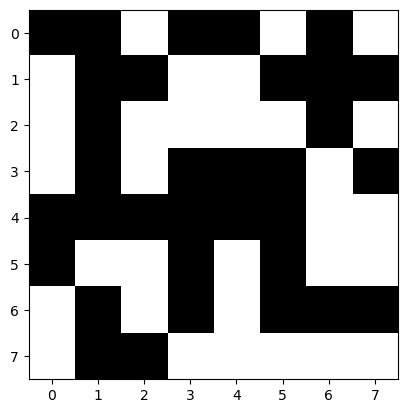

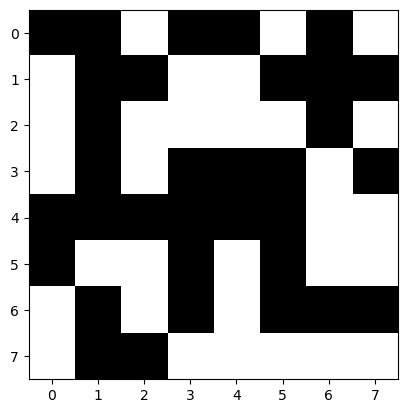

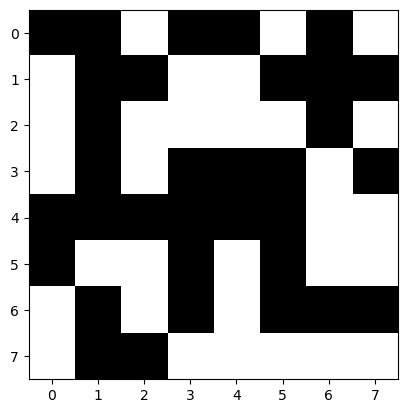

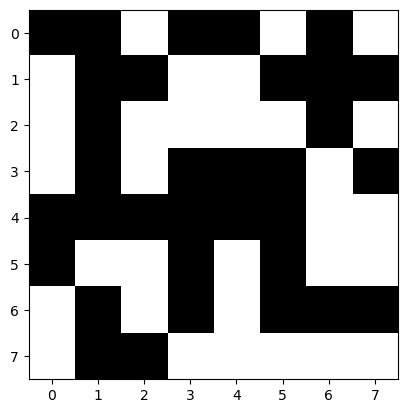

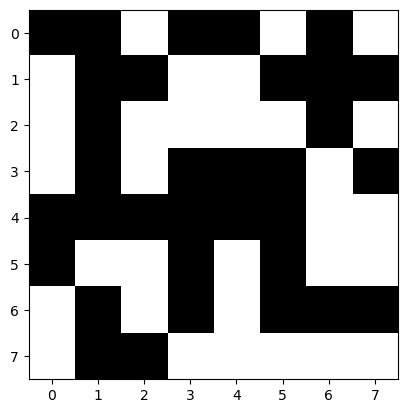

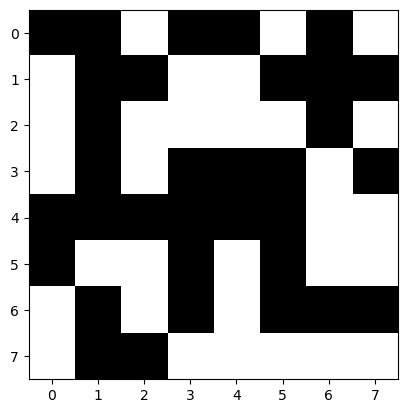

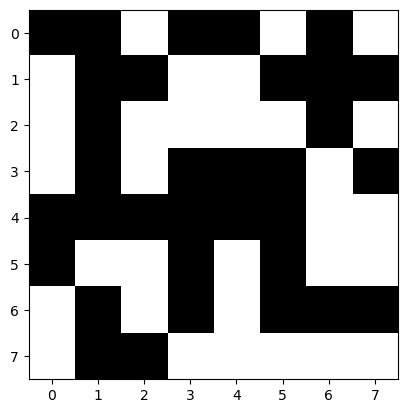

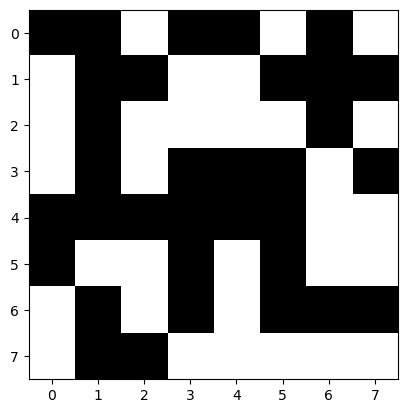

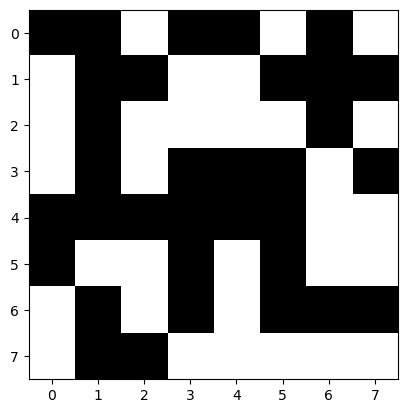

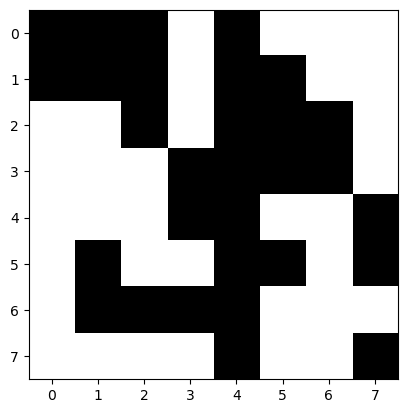

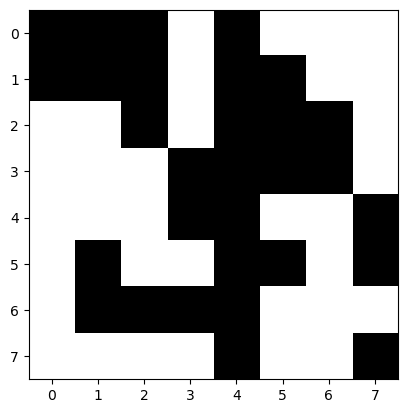

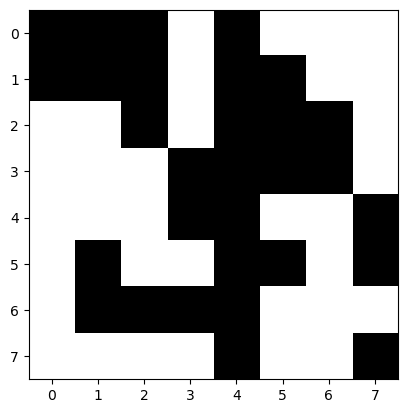

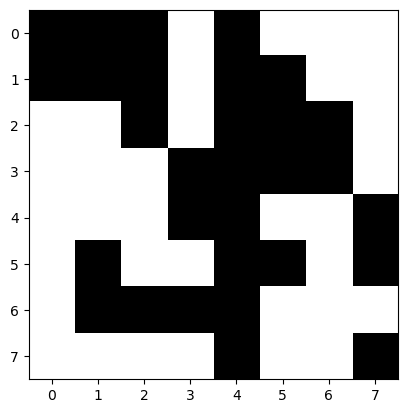

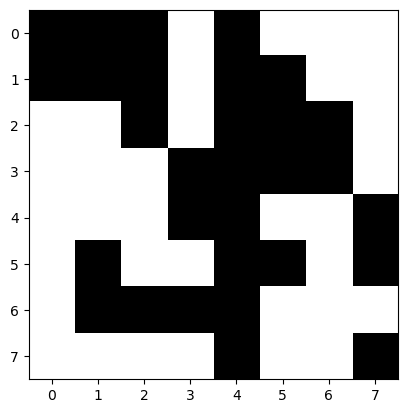

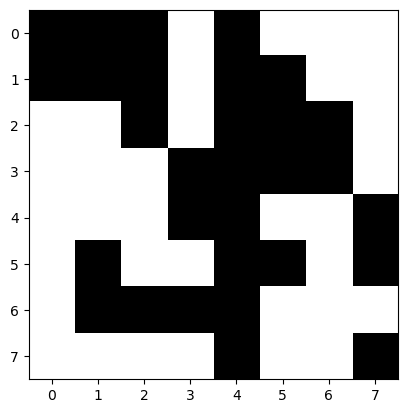

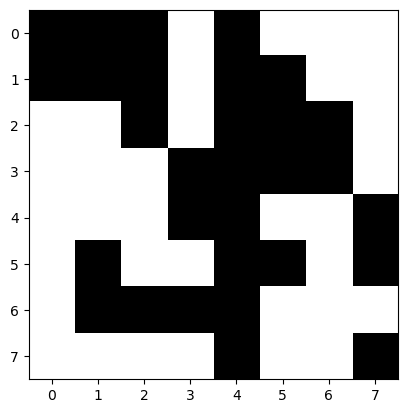

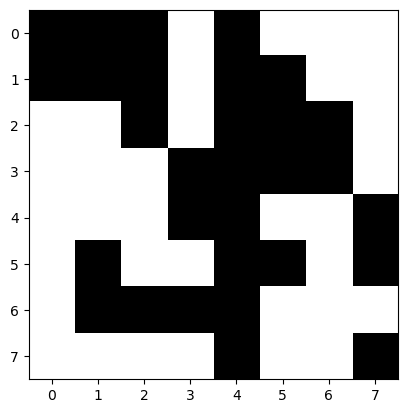

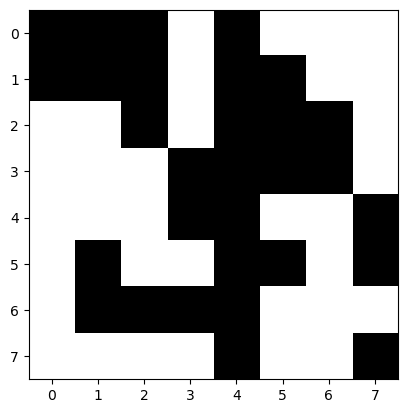

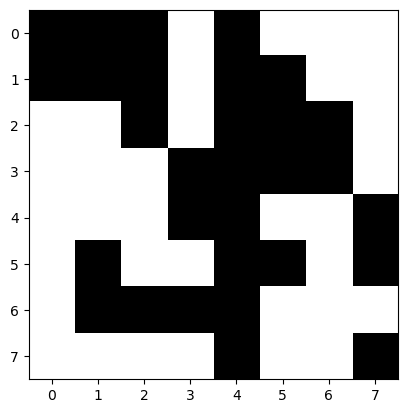

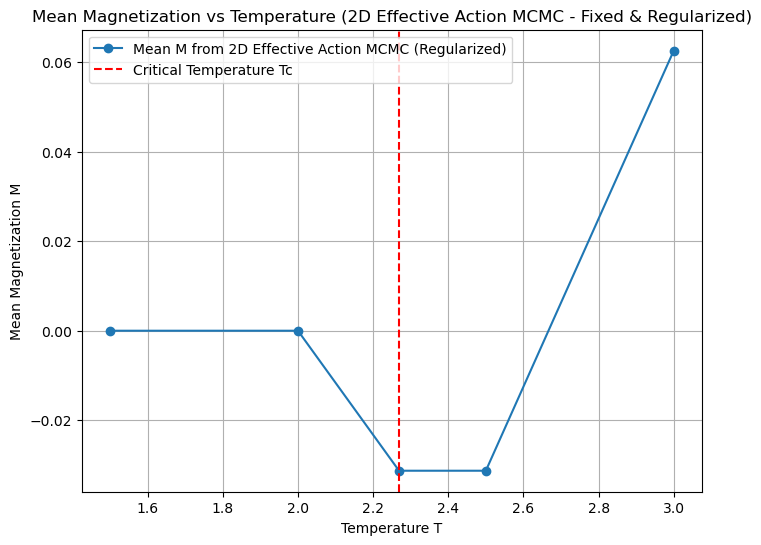

[0.0, 0.0, -0.03125, -0.03125, 0.0625]

In [30]:
# Apply Tikhonov Regularization to J_eff
lambda_reg = 0.01  # Small regularization parameter

# Store new effective actions with regularization
effective_actions_reg = {}

for T in temperatures:
    cov_m = np.cov(block_magnetization.reshape(num_samples, -1), rowvar=False)
    J_eff_reg = np.linalg.pinv(cov_m + lambda_reg * np.eye(cov_m.shape[0]))  # Regularized inverse
    effective_actions_reg[T] = J_eff_reg

# Re-run the 2D effective action MCMC with improved sampling
magnetization_vs_T_2D_fixed = {}

for T_reduced in temperatures:
    beta_reduced = 1 / T_reduced
    J_eff_reduced = effective_actions_reg[T_reduced]  # Get the regularized effective action

    # Run the 2D reduced Monte Carlo simulation
    reduced_samples_2D = metropolis_reduced_2D(num_samples, burn_in, J_eff_reduced, beta_reduced)

    # Compute mean magnetization (without absolute value)
    magnetization_vs_T_2D_fixed[T_reduced] = np.mean(reduced_samples_2D, axis=(1, 2))  # Mean over samples

# Plot mean magnetization vs temperature for the 2D effective action MCMC (with fluctuations)
plt.figure(figsize=(8, 6))
mean_magnetizations_2D_fixed = [np.mean(magnetization_vs_T_2D_fixed[T]) for T in temperatures]

plt.plot(temperatures, mean_magnetizations_2D_fixed, 'o-', label="Mean M from 2D Effective Action MCMC (Regularized)")
plt.axvline(x=2.269, linestyle="--", color="red", label="Critical Temperature Tc")
plt.xlabel("Temperature T")
plt.ylabel("Mean Magnetization M")
plt.title("Mean Magnetization vs Temperature (2D Effective Action MCMC - Fixed & Regularized)")
plt.legend()
plt.grid()
plt.show()

# Display computed magnetization values for debugging
mean_magnetizations_2D_fixed


Running MCMC for T = 1.5...


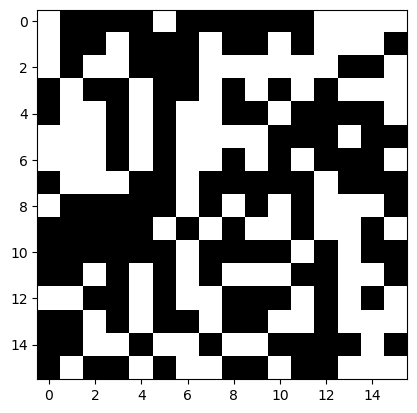

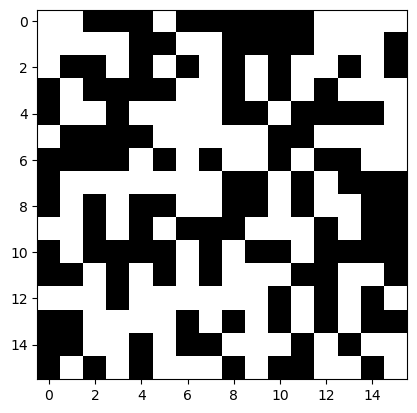

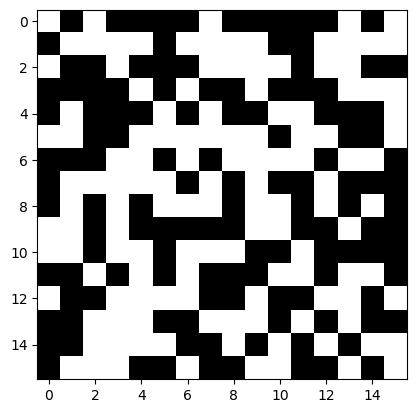

Running MCMC for T = 2.0...


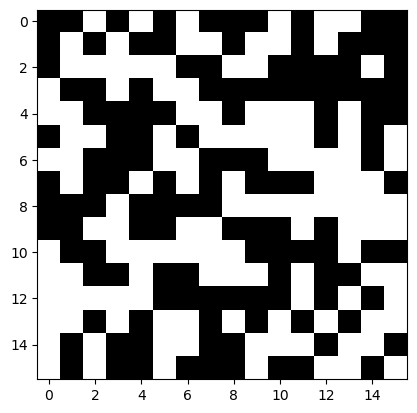

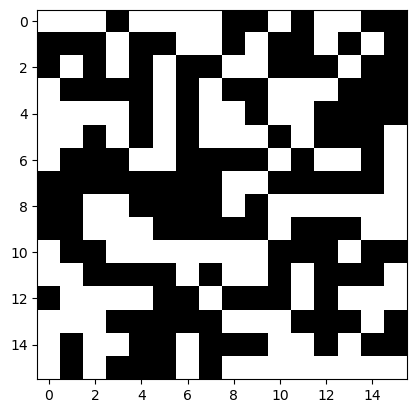

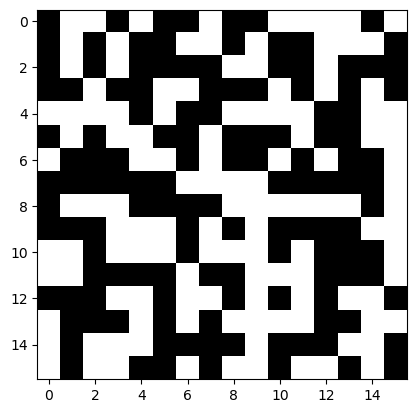

Running MCMC for T = 2.269...


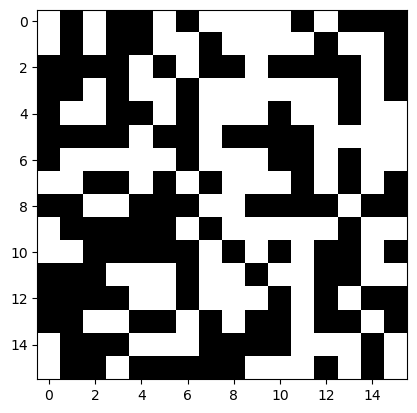

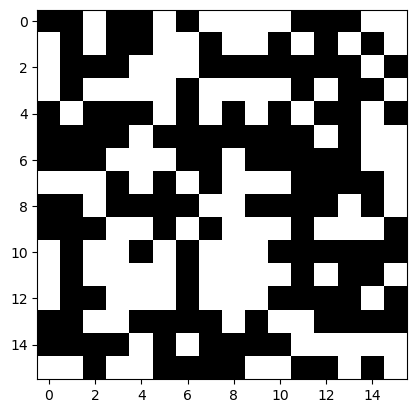

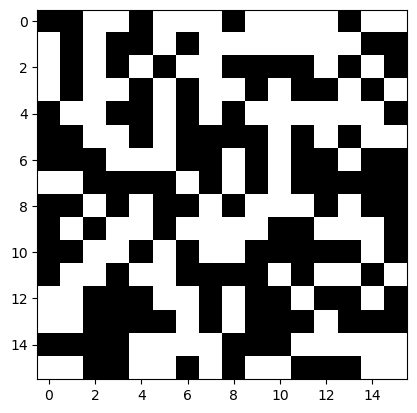

Running MCMC for T = 2.5...


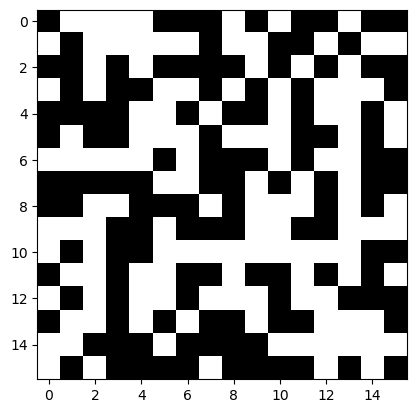

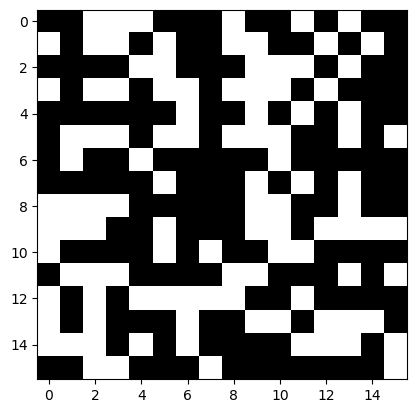

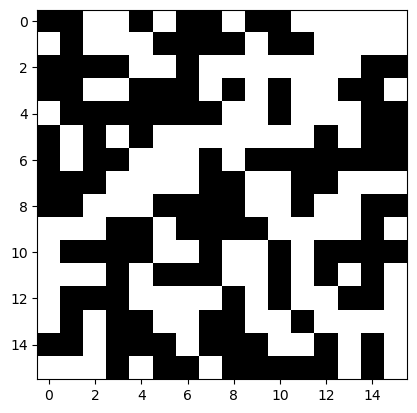

Running MCMC for T = 3.0...


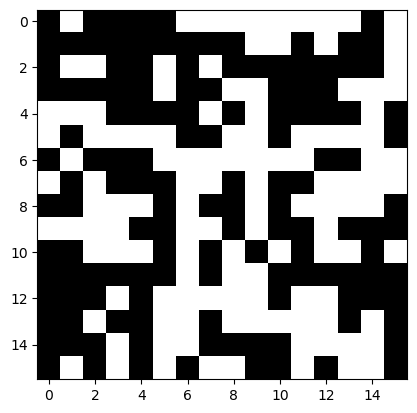

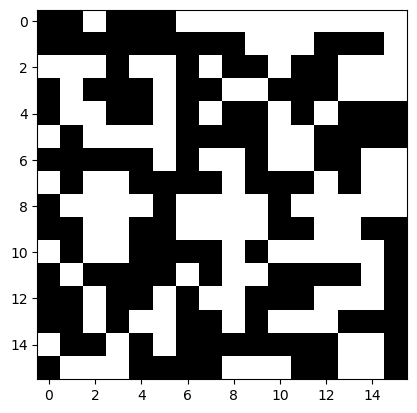

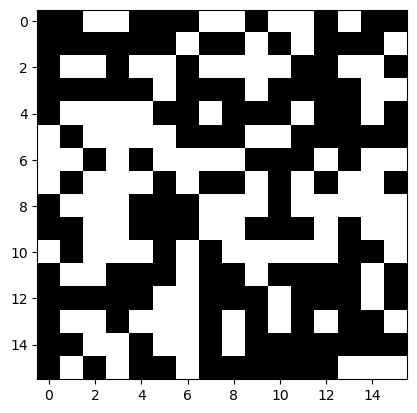

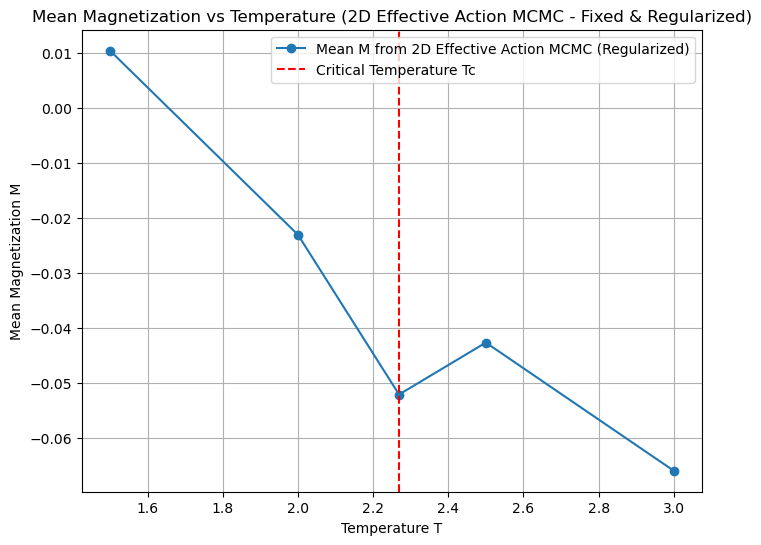

[0.010442708333333333,
 -0.023072916666666665,
 -0.052161458333333334,
 -0.042708333333333334,
 -0.06604166666666667]

In [36]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt

# Re-define Monte Carlo simulation using a 2D coarse-grained effective action
def metropolis_ising_2D(L, num_samples, burn_in, beta):
    """Perform Metropolis-Hastings sampling for a 2D Ising model."""
    spins = np.random.choice([-1, 1], size=(L, L))  # Initial random spin state
    samples = []

    for step in range(num_samples + burn_in):
        i, j = np.random.randint(0, L, size=2)  # Pick a random spin
        S = spins[i, j]
        
        # Compute energy change if flipped (nearest-neighbor interaction)
        neighbors = spins[(i + 1) % L, j] + spins[i, (j + 1) % L] + \
                    spins[(i - 1) % L, j] + spins[i, (j - 1) % L]
        delta_E = 2 * S * neighbors  # Energy difference
        
        # Metropolis acceptance criterion
        if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
            spins[i, j] *= -1  # Flip the spin

        # Store sample after burn-in
        if step >= burn_in:
            samples.append(spins.copy())

    return np.array(samples)

# Function to compute the coarse-grained magnetization in 2D
def coarse_grain_2D(spins, block_size):
    """Compute block-averaged magnetization for 2D Ising configurations."""
    L = spins.shape[1]  # Lattice size
    num_blocks = L // block_size  # Number of blocks in each dimension
    block_magnetization = np.zeros((spins.shape[0], num_blocks, num_blocks))

    for i in range(num_blocks):
        for j in range(num_blocks):
            block = spins[:, i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            block_magnetization[:, i, j] = np.mean(block, axis=(1, 2))  # Average spin in block

    return block_magnetization

# Function for Monte Carlo simulation using the 2D effective action
def metropolis_reduced_2D(num_samples, burn_in, J_eff, beta):
    """Monte Carlo simulation using the effective action with J_eff in 2D."""
    num_blocks_side = int(np.sqrt(J_eff.shape[0]))  # Recover 2D shape
    M = np.random.choice([-1, 1], size=(num_blocks_side, num_blocks_side))  # Initial magnetization state

    samples = []

    for step in range(num_samples + burn_in):
        i, j = np.random.randint(0, num_blocks_side, size=2)  # Pick a random site
        dE = 2 * M[i, j] * np.sum(J_eff[i * num_blocks_side + j] * M.flatten())  # Compute energy difference

        # Metropolis acceptance criterion
        if dE < 0 or np.random.rand() < np.exp(-beta * dE):
            M[i, j] *= -1  # Flip the spin

        # Store sample after burn-in
        if step >= burn_in:
            samples.append(M.copy())
            if step%100==0:
                plt.imshow(M, cmap="gray", interpolation="nearest")
                plt.show()  

    return np.array(samples)

# Simulation parameters
L = 64  # Lattice size (16x16 for better resolution)
num_samples = 300  # Number of Monte Carlo samples
burn_in = 100  # Burn-in steps
block_size = 4  # Coarse-graining scale
num_blocks = L // block_size

# Define temperatures to study
temperatures = [1.5, 2.0, 2.269, 2.5, 3.0]  # Below, near, and above Tc
beta_values = [1/T for T in temperatures]

# Store results
effective_actions = {}
magnetization_vs_T_2D = {}

# Run Monte Carlo simulations and extract effective actions
for beta, T in zip(beta_values, temperatures):
    print(f"Running MCMC for T = {T}...")

    # Step 1: Monte Carlo Simulation at Temperature T
    ising_samples = metropolis_ising_2D(L, num_samples, burn_in, beta)

    # Step 2: Compute Coarse-Grained Magnetization (2D Blocking)
    block_magnetization = coarse_grain_2D(ising_samples, block_size)

    # Step 3: Compute Second-Order Cumulant (Covariance in 2D)
    num_block_sites = num_blocks * num_blocks  # Total number of block magnetization sites
    M_x = block_magnetization.reshape(num_samples, num_block_sites)  # Flatten to match J_eff

    mean_m = np.mean(M_x, axis=0)  # First-order cumulant
    cov_m = np.cov(M_x, rowvar=False)  # Second-order cumulant

    # Apply Tikhonov Regularization to J_eff
    lambda_reg = 0.01  # Small regularization parameter
    J_eff = cov_m + lambda_reg * np.eye(cov_m.shape[0])# Regularized inverse

    # Store effective action components
    effective_actions[T] = J_eff

    # Step 4: Monte Carlo Simulation Using the Effective Action
    beta_reduced = 1 / T
    reduced_samples_2D = metropolis_reduced_2D(num_samples, burn_in, J_eff, beta_reduced)

    # Compute mean magnetization (without absolute value)
    magnetization_vs_T_2D[T] = np.mean(reduced_samples_2D, axis=(1, 2))  # Mean over samples

# Plot mean magnetization vs temperature for the 2D effective action MCMC (fixed)
plt.figure(figsize=(8, 6))
mean_magnetizations_2D_fixed = [np.mean(magnetization_vs_T_2D[T]) for T in temperatures]

plt.plot(temperatures, mean_magnetizations_2D_fixed, 'o-', label="Mean M from 2D Effective Action MCMC (Regularized)")
plt.axvline(x=2.269, linestyle="--", color="red", label="Critical Temperature Tc")
plt.xlabel("Temperature T")
plt.ylabel("Mean Magnetization M")
plt.title("Mean Magnetization vs Temperature (2D Effective Action MCMC - Fixed & Regularized)")
plt.legend()
plt.grid()
plt.show()

# Display computed magnetization values
mean_magnetizations_2D_fixed


Running MCMC for T = 1.5...
Running MCMC for T = 1.8...
Running MCMC for T = 2.1...
Running MCMC for T = 2.4...
Running MCMC for T = 2.7...
Running MCMC for T = 3.0...


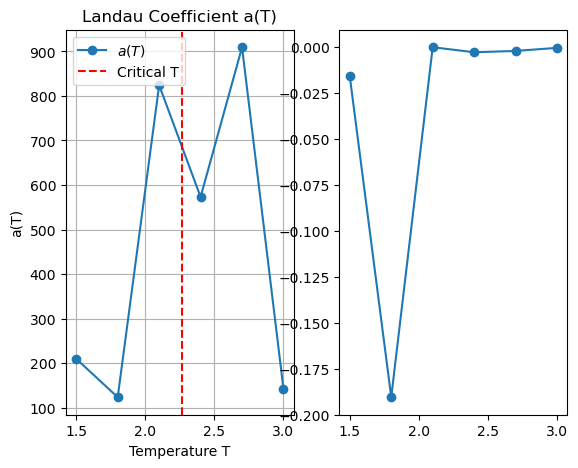

In [37]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo simulation for the microscopic 2D Ising model
def metropolis_ising_2D(L, num_samples, burn_in, beta):
    """Perform Metropolis-Hastings sampling for a 2D Ising model."""
    spins = np.random.choice([-1, 1], size=(L, L))  # Initial random spin state
    samples = []

    for step in range(num_samples + burn_in):
        i, j = np.random.randint(0, L, size=2)  # Pick a random spin
        S = spins[i, j]
        
        # Compute energy change if flipped (nearest-neighbor interaction)
        neighbors = spins[(i + 1) % L, j] + spins[i, (j + 1) % L] + \
                    spins[(i - 1) % L, j] + spins[i, (j - 1) % L]
        delta_E = 2 * S * neighbors  # Energy difference
        
        # Metropolis acceptance criterion
        if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
            spins[i, j] *= -1  # Flip the spin

        # Store sample after burn-in
        if step >= burn_in:
            samples.append(spins.copy())

    return np.array(samples)

# Compute magnetization moments for Landau coefficients
def compute_moments(spin_samples):
    """Compute second and fourth-order cumulants from Monte Carlo samples."""
    magnetization = np.mean(spin_samples, axis=(1, 2))  # Average magnetization per sample
    
    # Compute second-order cumulant (related to susceptibility)
    kappa_2 = np.mean(magnetization**2) - np.mean(magnetization)**2
    
    # Compute fourth-order cumulant (related to Landau coefficient b)
    kappa_4 = np.mean(magnetization**4) - 3 * (np.mean(magnetization**2))**2
    
    return kappa_2, kappa_4

# Compute spatial correlation function to estimate coefficient c
def compute_correlation_function(spin_samples):
    """Compute spatial correlations in Fourier space to extract c."""
    L = spin_samples.shape[1]
    magnetization_field = np.mean(spin_samples, axis=0)  # Mean magnetization field

    # Compute Fourier transform of the magnetization field
    M_k = np.fft.fft2(magnetization_field)
    power_spectrum = np.abs(M_k)**2  # Compute power spectrum

    # Extract correlation function from Fourier modes
    k_values = np.fft.fftfreq(L) * 2 * np.pi  # Convert to wavenumbers
    k_squared = k_values[:, None]**2 + k_values[None, :]**2  # Compute k^2 grid
    
    # Compute effective coefficient c by fitting power-law decay
    valid_indices = k_squared > 0  # Ignore zero mode
    c_value = np.mean(1 / (power_spectrum[valid_indices] * k_squared[valid_indices]))  # Approximate c

    return c_value

# Simulation parameters
L = 16  # Lattice size (16x16 for good statistics)
num_samples = 1000  # Number of Monte Carlo samples
burn_in = 500  # Burn-in steps

# Define temperatures
temperatures = np.linspace(1.5, 3.0, 6)  # Below, near, and above Tc
beta_values = 1 / temperatures

# Store extracted Ginzburg-Landau parameters
a_values = []
b_values = []
c_values = []

# Run Monte Carlo simulations and extract Landau parameters
for beta, T in zip(beta_values, temperatures):
    print(f"Running MCMC for T = {T}...")

    # Step 1: Monte Carlo simulation at Temperature T
    ising_samples = metropolis_ising_2D(L, num_samples, burn_in, beta)

    # Step 2: Compute second and fourth-order cumulants
    kappa_2, kappa_4 = compute_moments(ising_samples)

    # Step 3: Compute spatial correlation function to get c
    c_value = compute_correlation_function(ising_samples)

    # Step 4: Store extracted parameters
    a_values.append(1 / kappa_2)  # a(T) ∝ 1 / κ2
    b_values.append(kappa_4)  # b ∝ κ4
    c_values.append(c_value)  # Gradient coefficient

# Plot extracted coefficients
plt.figure(figsize=(10, 5))

# Plot a(T)
plt.subplot(1, 3, 1)
plt.plot(temperatures, a_values, 'o-', label=r"$a(T)$")
plt.axvline(x=2.269, linestyle="--", color="red", label="Critical T")
plt.xlabel("Temperature T")
plt.ylabel("a(T)")
plt.title("Landau Coefficient a(T)")
plt.legend()
plt.grid()

# Plot b(T)
plt.subplot(1, 3, 2)
plt.plot(temperatures, b_values, 'o-', label=r"$b(T)$")

